# Exploration of Nutrition and Costs


data sources:

- https://fdc.nal.usda.gov/download-datasets.html
- https://www.ers.usda.gov/data-products/fruit-and-vegetable-prices.aspx
- https://www.kaggle.com/datasets/trolukovich/nutritional-values-for-common-foods-and-products
- https://www.fda.gov/food/nutrition-facts-label/daily-value-nutrition-and-supplement-facts-labels

-https://marketnews.usda.gov/mnp/FVDataDownload

explored, but discarded:
- https://www.kaggle.com/datasets/thedevastator/the-nutritional-content-of-food-a-comprehensive
- https://www.kaggle.com/datasets/thunderz/food-data


inspiration sources:

- https://nutritionj.biomedcentral.com/articles/10.1186/s12937-019-0496-5
- https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2954450/
- https://www.healthline.com/nutrition/29-cheap-healthy-foods
- https://nutritionfacts.org/blog/best-nutrition-bang-for-your-buck/

## Idea/Work Backlog

- search manually for matches of Prices.Items that did NOT find any fuzzymatch (see 7.1)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load Nutrition and Assess 

In [2]:
# data source:
# https://www.kaggle.com/datasets/trolukovich/nutritional-values-for-common-foods-and-products

nutrition = pd.read_csv('data/nutrition.csv', index_col='Unnamed: 0')

In [3]:
nutrition.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8789 entries, 0 to 8788
Data columns (total 76 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   name                         8789 non-null   object
 1   serving_size                 8789 non-null   object
 2   calories                     8789 non-null   int64 
 3   total_fat                    8789 non-null   object
 4   saturated_fat                7199 non-null   object
 5   cholesterol                  8789 non-null   object
 6   sodium                       8789 non-null   object
 7   choline                      8789 non-null   object
 8   folate                       8789 non-null   object
 9   folic_acid                   8789 non-null   object
 10  niacin                       8789 non-null   object
 11  pantothenic_acid             8789 non-null   object
 12  riboflavin                   8789 non-null   object
 13  thiamin                      8789

In [4]:
nutrition.head()

,name,serving_size,calories,total_fat,saturated_fat,cholesterol,sodium,choline,folate,folic_acid,...,fat,saturated_fatty_acids,monounsaturated_fatty_acids,polyunsaturated_fatty_acids,fatty_acids_total_trans,alcohol,ash,caffeine,theobromine,water
0,Cornstarch,100 g,381,0.1g,NaN,0,9.00 mg,0.4 mg,0.00 mcg,0.00 mcg,...,0.05 g,0.009 g,0.016 g,0.025 g,0.00 mg,0.0 g,0.09 g,0.00 mg,0.00 mg,8.32 g
1,"Nuts, pecans",100 g,691,72g,6.2g,0,0.00 mg,40.5 mg,22.00 mcg,0.00 mcg,...,71.97 g,6.180 g,40.801 g,21.614 g,0.00 mg,0.0 g,1.49 g,0.00 mg,0.00 mg,3.52 g
2,"Eggplant, raw",100 g,25,0.2g,NaN,0,2.00 mg,6.9 mg,22.00 mcg,0.00 mcg,...,0.18 g,0.034 g,0.016 g,0.076 g,0.00 mg,0.0 g,0.66 g,0.00 mg,0.00 mg,92.30 g
3,"Teff, uncooked",100 g,367,2.4g,0.4g,0,12.00 mg,13.1 mg,0,0,...,2.38 g,0.449 g,0.589 g,1.071 g,0,0,2.37 g,0,0,8.82 g
4,"Sherbet, orange",100 g,144,2g,1.2g,1mg,46.00 mg,7.7 mg,4.00 mcg,0.00 mcg,...,2.00 g,1.160 g,0.530 g,0.080 g,1.00 mg,0.0 g,0.40 g,0.00 mg,0.00 mg,66.10 g


In [5]:
nutrition[nutrition.name=='Wheat flour, whole-grain'].T

,683
name,"Wheat flour, whole-grain"
serving_size,100 g
calories,340
total_fat,2.5g
saturated_fat,0.4g
...,...
alcohol,0.0 g
ash,1.58 g
caffeine,0.00 mg
theobromine,0.00 mg


In [6]:
# will use this food dataset since all are 100g serving sizes
# but will need to parse the nutrients from string to numbers and units of measure

# Categorize based on most frequent words

## Identify Categories

In [7]:
# split the name into lists in orders to find the most frequently used words

nutrition['name_split'] = nutrition['name'].apply(lambda x: x.replace(",", "").split())

words = pd.Series([word for EachElement in nutrition['name_split'] for word in EachElement])
words.value_counts()

and          2092
fat          1994
cooked       1785
lean         1508
separable    1457
             ... 
VITAMAN         1
FRUITY          1
beaked          1
Hazelnuts       1
degree          1
Length: 4514, dtype: int64

In [8]:
words.value_counts().quantile(q=[0,0.25, 0.50, 0.75, 0.99, 0.999, 0.9999, 1])

0.0000       1.0000
0.2500       1.0000
0.5000       2.0000
0.7500       7.0000
0.9900     242.4800
0.9990    1422.6290
0.9999    2047.7726
1.0000    2092.0000
dtype: float64

In [9]:
# top 83 words (of distinct 4514!) is top 50 percent of word counts

(words.value_counts().cumsum()/words.value_counts().sum()).iloc[83]

0.49999273414226547

In [10]:
# look up each top word, then look up `name` with that word, analyze, identify groupings

###########

# words of interest for categorization:

# FOODS
# Babyfood: 'Babyfood'
# Beef: 'Beef'
# Chicken: 'Chicken'
# Pork: 'Pork'
# Lamb: 'Lamb'
# Fish: 'Fish'
# Cheese: 'Cheese'
# Crackers: 'Crackers'
# Soup: 'Soup'
# Cereals: 'Cereals'

# STORAGE STATE
# Fresh: ['fresh', 'raw']
# Frozen: ['frozen', 'raw or frozen']
# Canned: 'canned'
# Dried: 'dry'

# PREPARED
# cooked: 'cooked'
# roasted: 'roasted'
# boiled: 'boiled'
# drained: 'drained'    ## typically with 'boiled'
# solids: ['drained solids', 'solids and liquids']
# prepared: 'prepared'
# uprepared: 'unprepared'
# salt: [without salt, with salt, no salt added]  ## sodium?

# ATTRIBUTES
# boneless: 'boneless'
# fat: ['low fat', 'fat free', 'reducted fat', ...]
# skin: ['skin', 'with skin, without skin', 'meat and skin', 'cooked without skin']

# GRADE
# all: ['all varieties', 'all types', 'all grades']
# choice: 'choice' #like preferred or premium?
# select: 'select' # similar to choice
# imported: imported
# ready-to-eat:ready-to-eat

##################
# explore later
# lean: 'separable lean only', X% fat Y% lean 
# meat:
# water:

theWord = words.value_counts().index[130]
theWord

'sodium'

In [11]:
# lookup records where `name` contains the word

nutrition[nutrition['name_split'].apply(lambda x: theWord in x)].name#.iloc[:50]

282                                    Catsup, low sodium
734                         Beef, reduced sodium, bologna
739                         Peanut butter, reduced sodium
797                          Crackers, low sodium, cheese
813                          Cheese, low sodium, parmesan
                              ...                        
8092    Beverages, prepared with water, without added ...
8217    Luncheon meat, 25% less sodium, includes SPAM,...
8234    Beverages, without added sodium or vitamin A, ...
8491    Gelatin desserts, vitamin C, sodium, potassium...
8694    Carbonated beverage, without caffeine, with so...
Name: name, Length: 87, dtype: object

In [12]:
# value count of prhases found by regex

(nutrition[nutrition['name_split']
           .apply(lambda x: theWord in x)]
           .name
           .str.extract(r",([^,]*{0}[^,\n]*)[,\n]".format(theWord))
           .value_counts()
)

 low sodium                                        31
 reduced sodium                                    20
 with sodium saccharin                              2
 less/reduced sodium                                2
 sodium                                             2
  lower sodium                                      1
 reduced/low sodium                                 1
 without added sodium                               1
 with lauric acid oil and sodium caseinate          1
 with added potassium and sodium                    1
 very low sodium                                    1
 sweetened with sodium saccharin                    1
 sodium aluminum sulfate                            1
 no sodium added                                    1
 25% less sodium                                    1
 no added sodium                                    1
 lower sodium                                       1
 low sodium no salt                                 1
 low sodium (includes bread 

## Apply Categories

Based on the groupings study above and the development of some dictionaries, functions below are built to implement the categorization.


In [13]:
import re

In [14]:
def categorize(TheSeries: pd.Series, pattern: list, category: str, regex=False):
    if type(pattern) == list:
        for eachItem in pattern:
            if regex:
                pat = fr',([^,]*{eachItem}[^,\n]*)[,\n]'
                return TheSeries.name.apply(lambda x: category if re.search(pat,x) else '')
            else:
                return TheSeries.apply(lambda x: category if eachItem in x else '')
    elif type(pattern) == str:
        if regex:
            pat = fr',([^,]*{pattern}[^,\n]*)[,\n]'
            return TheSeries.apply(lambda x: category if re.search(pat,x) else '')
        else:
            return TheSeries.apply(lambda x: category if pattern in x else '')
    else:
        print("'pattern' parameter dtype is expected to be either str or list")

In [15]:
def bulk_categorize(theSeries: pd.Series, theDict: dict, column_name, regex=False):
    temp_df = pd.DataFrame()
    for key in theDict:
        tempSeries = categorize(theSeries, theDict[key], key, regex)
        temp_df[key] = tempSeries
    temp_df[column_name] = temp_df.apply(lambda row: ''.join(str(val) for val in row), axis=1)
    temp_df = temp_df[[column_name]]
    return temp_df

In [16]:
# new functions

In [21]:
def categorize(the_series: pd.Series, pattern: str, category: str, regex=False):
    if regex:
        pat = fr',([^,]*{pattern}[^,\n]*)[,\n]'
        return the_series.apply(lambda x: category if re.search(pat,x) else '')
    else:
        return the_series.apply(lambda x: category if pattern in x else '')

In [22]:
def bulk_categorize(theSeries: pd.Series, theDict: dict, column_name, regex=False):
    
    temp_df = pd.DataFrame()
    temp_series = pd.Series(dtype=str)
    
    for key in theDict:
        if type(theDict[key])==list:
            for eachItem in theDict[key]:
                temp_series = categorize(theSeries, eachItem, key)
                temp_df[eachItem] = temp_series
        else:
            temp_series = categorize(theSeries, theDict[key], key)
            temp_df[key] = temp_series

    temp_df[column_name] = temp_df.apply(lambda row: ''.join(str(val) for val in row), axis=1)
    temp_df = temp_df[[column_name]]
    return temp_df

In [23]:
food_types_dict = {
    'Babyfood': 'Babyfood',
    'Beef': 'Beef',
    'Chicken': 'Chicken',
    'Pork': 'Pork',
    'Lamb': 'Lamb',
    'Fish': 'Fish',
    'Cheese': 'Cheese',
    'Crackers': 'Crackers',
    'Soup': 'Soup',
    'Cereals': 'Cereals'
}

storage_state_dict = {
    'Fresh': ['fresh', 'raw'],
    'Frozen': ['frozen', 'raw or frozen'],
    'Canned': 'canned',
    'Dried': ['dry','dehydrated','dried']
}

grade_dict = {
    'all': ['all varieties', 'all types', 'all grades'],
    'choice': 'choice',
    'select': 'select',
    'imported': 'imported',
    'ready_to_eat':'ready-to-eat'
}

salt_dict = {
    'No Salt':['without salt', 'without added sodium', 'no sodium', 
               'no added sodium', 'no salt added', 'without added salt',
               'no salt', 'no added salt', 'without salt added'],
    'Low Salt':['low sodium', 'reduced sodium', 'lower sodium', 'less sodium', 'low salt'],
    'Salt':['with sodium', 'with salt', 'salt added', 'salt']    
}

In [24]:
s = bulk_categorize(nutrition.name, food_types_dict, 'food_types')
t = bulk_categorize(nutrition.name, storage_state_dict, 'storage_state')
u = bulk_categorize(nutrition.name, grade_dict, 'grade')
v = bulk_categorize(nutrition.name, salt_dict, 'Salt', regex=True)
nutrition = pd.concat([nutrition, s, t, u, v],axis=1)
nutrition

,name,serving_size,calories,total_fat,saturated_fat,cholesterol,sodium,choline,folate,folic_acid,...,alcohol,ash,caffeine,theobromine,water,name_split,food_types,storage_state,grade,Salt
0,Cornstarch,100 g,381,0.1g,NaN,0,9.00 mg,0.4 mg,0.00 mcg,0.00 mcg,...,0.0 g,0.09 g,0.00 mg,0.00 mg,8.32 g,[Cornstarch],,,,
1,"Nuts, pecans",100 g,691,72g,6.2g,0,0.00 mg,40.5 mg,22.00 mcg,0.00 mcg,...,0.0 g,1.49 g,0.00 mg,0.00 mg,3.52 g,"[Nuts, pecans]",,,,
2,"Eggplant, raw",100 g,25,0.2g,NaN,0,2.00 mg,6.9 mg,22.00 mcg,0.00 mcg,...,0.0 g,0.66 g,0.00 mg,0.00 mg,92.30 g,"[Eggplant, raw]",,Fresh,,
3,"Teff, uncooked",100 g,367,2.4g,0.4g,0,12.00 mg,13.1 mg,0,0,...,0,2.37 g,0,0,8.82 g,"[Teff, uncooked]",,,,
4,"Sherbet, orange",100 g,144,2g,1.2g,1mg,46.00 mg,7.7 mg,4.00 mcg,0.00 mcg,...,0.0 g,0.40 g,0.00 mg,0.00 mg,66.10 g,"[Sherbet, orange]",,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8784,"Beef, raw, all grades, trimmed to 0"" fat, sepa...",100 g,125,3.5g,1.4g,62mg,54.00 mg,64.5 mg,4.00 mcg,0.00 mcg,...,0.0 g,1.11 g,0.00 mg,0.00 mg,72.51 g,"[Beef, raw, all, grades, trimmed, to, 0"", fat,...",Beef,Fresh,all,
8785,"Lamb, cooked, separable lean only, composite o...",100 g,206,8.9g,3.9g,109mg,50.00 mg,0,0.00 mcg,0.00 mcg,...,0,1.60 g,0,0,59.95 g,"[Lamb, cooked, separable, lean, only, composit...",Lamb,Frozen,imported,
8786,"Lamb, raw, separable lean and fat, composite o...",100 g,277,23g,12g,78mg,39.00 mg,0,1.00 mcg,0.00 mcg,...,0,0.92 g,0,0,59.80 g,"[Lamb, raw, separable, lean, and, fat, composi...",Lamb,FreshFrozen,imported,
8787,"Beef, raw, all grades, trimmed to 0"" fat, sepa...",100 g,121,3g,1.1g,60mg,53.00 mg,64.2 mg,4.00 mcg,0.00 mcg,...,0.0 g,1.10 g,0.00 mg,0.00 mg,73.43 g,"[Beef, raw, all, grades, trimmed, to, 0"", fat,...",Beef,Fresh,all,


# EDA on Categories

In [25]:
# still a lot of records without a `food type`

nutrition.food_types.value_counts()

                     5446
Beef                  972
Cereals               352
Pork                  344
Chicken               302
Lamb                  300
Babyfood              243
Fish                  239
Soup                  235
Cheese                153
Crackers              120
ChickenSoup            45
BeefSoup               16
CheeseCrackers         12
CheeseSoup              6
CheeseCereals           2
CrackersSoup            1
ChickenCheeseSoup       1
Name: food_types, dtype: int64

In [26]:
nutrition[nutrition.food_types=='CheeseCereals'].name.iloc[0]

"Cereals, dry, Ham 'n' Cheese flavor, Instant Grits, QUAKER"

In [27]:
nutrition[nutrition.food_types=='CrackersSoup'].name.iloc[0]

'SUNSHINE, Soup & Oyster Crackers (large), KRISPY'

In [28]:
nutrition[nutrition.food_types=='ChickenCheeseSoup'].name.iloc[0]

"CAMPBELL'S CHUNKY Soups, Chicken Broccoli Cheese & Potato Soup"

In [29]:
nutrition.groupby('food_types').agg({'calories':'mean'}).sort_values('calories', ascending=False)

,calories
food_types,
CheeseCrackers,487.833333
Crackers,455.966667
CrackersSoup,416.000000
CheeseCereals,357.500000
Cereals,341.744318
Cheese,279.490196
,232.385053
Lamb,230.956667
Pork,214.729651


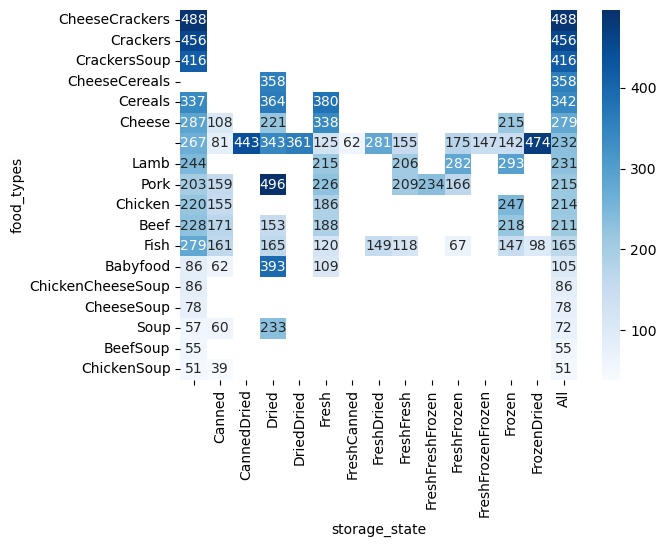

In [30]:
sns.heatmap(nutrition.pivot_table(index='food_types', values='calories', columns='storage_state', aggfunc='mean', margins=True)
            .drop('All')
            .sort_values('All',ascending=False)
            , annot=True, fmt='.0f', cmap='Blues'
           );

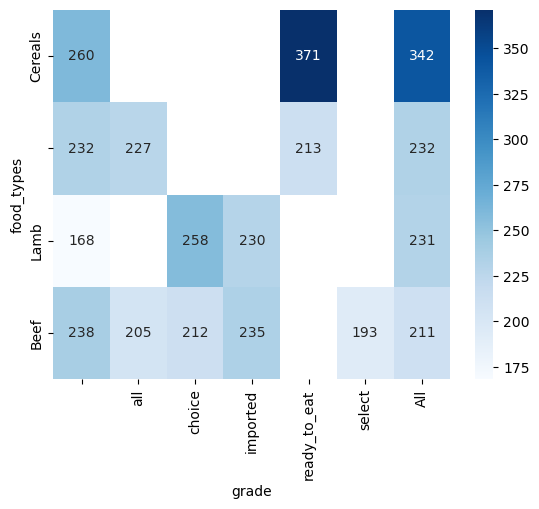

In [31]:
sns.heatmap(nutrition.pivot_table(index='food_types', values='calories', columns='grade', aggfunc='mean', margins=True)
            .drop('All')
            .dropna(how='all',subset=['all','choice','imported','ready_to_eat','select'])
            .sort_values('All',ascending=False)
            , annot=True, fmt='.0f', cmap='Blues'
           );

## understanding more about the uncategorized items

In [32]:
nutrition[nutrition.food_types==""]

,name,serving_size,calories,total_fat,saturated_fat,cholesterol,sodium,choline,folate,folic_acid,...,alcohol,ash,caffeine,theobromine,water,name_split,food_types,storage_state,grade,Salt
0,Cornstarch,100 g,381,0.1g,NaN,0,9.00 mg,0.4 mg,0.00 mcg,0.00 mcg,...,0.0 g,0.09 g,0.00 mg,0.00 mg,8.32 g,[Cornstarch],,,,
1,"Nuts, pecans",100 g,691,72g,6.2g,0,0.00 mg,40.5 mg,22.00 mcg,0.00 mcg,...,0.0 g,1.49 g,0.00 mg,0.00 mg,3.52 g,"[Nuts, pecans]",,,,
2,"Eggplant, raw",100 g,25,0.2g,NaN,0,2.00 mg,6.9 mg,22.00 mcg,0.00 mcg,...,0.0 g,0.66 g,0.00 mg,0.00 mg,92.30 g,"[Eggplant, raw]",,Fresh,,
3,"Teff, uncooked",100 g,367,2.4g,0.4g,0,12.00 mg,13.1 mg,0,0,...,0,2.37 g,0,0,8.82 g,"[Teff, uncooked]",,,,
4,"Sherbet, orange",100 g,144,2g,1.2g,1mg,46.00 mg,7.7 mg,4.00 mcg,0.00 mcg,...,0.0 g,0.40 g,0.00 mg,0.00 mg,66.10 g,"[Sherbet, orange]",,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8767,"Toddler formula, ready-to-feed, ENFAGROW PREMI...",100 g,64,3.6g,1.6g,1mg,25.00 mg,8.0 mg,11.00 mcg,11.00 mcg,...,0.0 g,0.50 g,0.00 mg,0.00 mg,87.50 g,"[Toddler, formula, ready-to-feed, ENFAGROW, PR...",,,,
8770,"Infant formula, with ARA and DHA, SENSITIVE (L...",100 g,68,3.7g,2.4g,2mg,21.00 mg,11.1 mg,10.00 mcg,10.00 mcg,...,0.0 g,0.75 g,0.00 mg,0.00 mg,87.00 g,"[Infant, formula, with, ARA, and, DHA, SENSITI...",,,,
8771,"Infant formula, not reconstituted, liquid conc...",100 g,128,6.5g,2.8g,0,46.00 mg,15.7 mg,20.00 mcg,20.00 mcg,...,0.0 g,0.80 g,0.00 mg,0.00 mg,75.40 g,"[Infant, formula, not, reconstituted, liquid, ...",,,,
8772,"Pan Dulce, contains wheat flour and rice flour...",100 g,445,16g,NaN,0,0,0,0,0,...,0,1.68 g,0,0,7.12 g,"[Pan, Dulce, contains, wheat, flour, and, rice...",,,,


In [33]:
nutrition[nutrition.food_types==""]['storage_state'].value_counts()

                     3628
Fresh                 665
Frozen                385
Canned                375
Dried                 356
FreshFrozen            18
FreshFresh              9
DriedDried              3
FrozenDried             2
FreshCanned             2
FreshFrozenFrozen       1
FreshDried              1
CannedDried             1
Name: storage_state, dtype: int64

In [34]:
words = pd.Series([word for EachElement in nutrition[(nutrition.food_types=="") & (nutrition.storage_state=="")]['name_split'] for word in EachElement])
words.value_counts().head(20)

with         764
cooked       585
and          479
salt         406
boiled       272
Beverages    248
without      239
Cookies      211
drained      187
fat          171
prepared     165
Candies      147
chocolate    147
added        141
Snacks       139
white        130
Fast         119
Infant       119
from         118
meat         117
dtype: int64

# transform Nutrition from wide to long

In [35]:
# transform from wide to long

food = nutrition.drop('name_split', axis=1).melt(id_vars=['name','food_types','storage_state','grade', 'Salt'])
food['value'] = food['value'].values.astype(str)
food.head()



,name,food_types,storage_state,grade,Salt,variable,value
0,Cornstarch,,,,,serving_size,100 g
1,"Nuts, pecans",,,,,serving_size,100 g
2,"Eggplant, raw",,Fresh,,,serving_size,100 g
3,"Teff, uncooked",,,,,serving_size,100 g
4,"Sherbet, orange",,,,,serving_size,100 g


In [36]:
pattern = r'(\d+(?:\.\d+)?)\s?(\D+)?'
food[['amount','unit of measure']] = food['value'].str.extract(pattern)
food['amount'] = pd.to_numeric(food['amount'],errors='coerce')

In [37]:
food[food['name']=='Wheat flour, whole-grain'].head(60)

,name,food_types,storage_state,grade,Salt,variable,value,amount,unit of measure
683,"Wheat flour, whole-grain",,,,,serving_size,100 g,100.000,g
9472,"Wheat flour, whole-grain",,,,,calories,340,340.000,NaN
18261,"Wheat flour, whole-grain",,,,,total_fat,2.5g,2.500,g
27050,"Wheat flour, whole-grain",,,,,saturated_fat,0.4g,0.400,g
35839,"Wheat flour, whole-grain",,,,,cholesterol,0,0.000,NaN
44628,"Wheat flour, whole-grain",,,,,sodium,2.00 mg,2.000,mg
53417,"Wheat flour, whole-grain",,,,,choline,31.2 mg,31.200,mg
62206,"Wheat flour, whole-grain",,,,,folate,44.00 mcg,44.000,mcg
70995,"Wheat flour, whole-grain",,,,,folic_acid,0.00 mcg,0.000,mcg
79784,"Wheat flour, whole-grain",,,,,niacin,4.957 mg,4.957,mg


In [38]:
food = food.drop(labels=['value'], axis=1)
food

,name,food_types,storage_state,grade,Salt,variable,amount,unit of measure
0,Cornstarch,,,,,serving_size,100.00,g
1,"Nuts, pecans",,,,,serving_size,100.00,g
2,"Eggplant, raw",,Fresh,,,serving_size,100.00,g
3,"Teff, uncooked",,,,,serving_size,100.00,g
4,"Sherbet, orange",,,,,serving_size,100.00,g
...,...,...,...,...,...,...,...,...
659170,"Beef, raw, all grades, trimmed to 0"" fat, sepa...",Beef,Fresh,all,,water,72.51,g
659171,"Lamb, cooked, separable lean only, composite o...",Lamb,Frozen,imported,,water,59.95,g
659172,"Lamb, raw, separable lean and fat, composite o...",Lamb,FreshFrozen,imported,,water,59.80,g
659173,"Beef, raw, all grades, trimmed to 0"" fat, sepa...",Beef,Fresh,all,,water,73.43,g


# Load Price Data

In [39]:
fruit = pd.read_csv('https://www.ers.usda.gov/webdocs/DataFiles/51035/Fruit%20Prices%202020.csv')
veg = pd.read_csv('https://www.ers.usda.gov/webdocs/DataFiles/51035/Vegetable%20Prices%202020.csv')

In [40]:
fruit = fruit.rename(columns={ fruit.columns[0]: "Item" })
veg = veg.rename(columns={ veg.columns[0]: "Item" })
prices = pd.concat([fruit, veg]).reset_index(drop=True)
prices.tail()

,Item,Form,RetailPrice,RetailPriceUnit,Yield,CupEquivalentSize,CupEquivalentUnit,CupEquivalentPrice
150,Tomatoes,Canned,1.0175,per pound,1.0000,0.5401,pounds,0.5496
151,Turnip greens,Fresh,2.4176,per pound,0.7500,0.3197,pounds,1.0304
152,Turnip greens,Canned,1.0429,per pound,0.6500,0.3527,pounds,0.5660
153,Turnip greens,Frozen,1.9451,per pound,0.7760,0.3527,pounds,0.8841
154,Zucchini,Fresh,1.5489,per pound,0.7695,0.3968,pounds,0.7987


In [41]:
# everything is per pound (convertable to grams), except Juice which is not of interest

prices.groupby(['RetailPriceUnit','Form'])['Item'].count()

RetailPriceUnit  Form  
per pint         Juice     11
per pound        Canned    36
                 Dried     17
                 Fresh     66
                 Frozen    25
Name: Item, dtype: int64

In [42]:
prices = (prices[~(prices['RetailPriceUnit'] == 'per pint')]
          .drop(['RetailPriceUnit', 'Yield','CupEquivalentSize','CupEquivalentUnit','CupEquivalentPrice'],axis=1)
          .copy()
         )

In [43]:
GRAMS_PER_POUND = 453.5924
prices['PricePer100Grams'] = prices['RetailPrice']/GRAMS_PER_POUND*100
prices.head()

,Item,Form,RetailPrice,PricePer100Grams
0,Apples,Fresh,1.5193,0.334948
1,"Apples, applesauce",Canned,1.0660,0.235013
4,Apricots,Fresh,2.9665,0.654001
5,"Apricots, packed in juice",Canned,1.6905,0.372691
6,"Apricots, packed in syrup or water",Canned,2.0600,0.454152


# Fuzzy Match Analysis

In [44]:
# fuzzymatch food.name with prices.Item

from rapidfuzz import process, fuzz

In [45]:
nutrition.storage_state.unique()

array(['', 'Fresh', 'Dried', 'Canned', 'FreshFrozenFrozen', 'FreshFresh',
       'Frozen', 'FrozenDried', 'FreshDried', 'FreshFrozen',
       'FreshCanned', 'DriedDried', 'FreshFreshFrozen', 'CannedDried'],
      dtype=object)

In [46]:
# unique double food_types

nutrition.storage_state.value_counts()[-3:]

FreshFrozenFrozen    1
FreshFreshFrozen     1
CannedDried          1
Name: storage_state, dtype: int64

In [47]:
# FreshDried, FreshFrozen, ForzenDried
# checking if any are of importance
# negative; these can be dropped from the analysis

(nutrition[nutrition.storage_state.isin(
            nutrition.storage_state.value_counts()[-3:].index
                                        )
          ]
 [['food_types','name','storage_state']]
 .sort_values('food_types')
)

,food_types,name,storage_state
53,,"Durian, raw or frozen",FreshFrozenFrozen
6123,,"Nuts, canned, flaked, sweetened, dried (desicc...",CannedDried
5809,Pork,"Pork, raw, frozen, ears, variety meats and by-...",FreshFreshFrozen


In [48]:
prices.Form.unique()

array(['Fresh', 'Canned', 'Dried', 'Frozen'], dtype=object)

In [49]:
# replace "Mangoes" to "Mangos" in order to match 

prices.Item = prices.Item.replace('Mangoes','Mangos')

In [50]:
prices[prices['Form']=='Fresh'][-20:]

,Item,Form,RetailPrice,PricePer100Grams
108,Green peppers,Fresh,1.2772,0.281574
109,Kale,Fresh,2.5018,0.551552
114,"Lettuce, iceberg",Fresh,0.9952,0.219404
115,"Lettuce, romaine, heads",Fresh,1.8299,0.403424
116,"Lettuce, romaine, hearts",Fresh,2.5766,0.568043
124,"Mushrooms, whole",Fresh,3.4464,0.759801
125,"Mushrooms, sliced",Fresh,3.6417,0.802857
130,Okra,Fresh,3.9803,0.877506
133,Onions,Fresh,0.9751,0.214973
136,Potatoes,Fresh,0.6682,0.147313


In [51]:
# exploration of different scorers and thresholds for optimal matching

query = prices[prices['Form']=='Fresh']['Item'].iloc[49]
choices = nutrition[(nutrition['storage_state']=='Fresh') | (nutrition['storage_state']=='')]['name']

print(query)

for each_scorer in [fuzz.partial_ratio
,fuzz.partial_token_ratio
,fuzz.partial_token_set_ratio
,fuzz.partial_token_sort_ratio
,fuzz.QRatio
,fuzz.ratio
,fuzz.token_ratio
,fuzz.token_set_ratio
,fuzz.token_sort_ratio
,fuzz.WRatio]:

    # print(each_scorer.func_name, isinstance(each_scorer, float))
    print(len(process.extract(query=query, choices=choices, scorer=each_scorer, limit=None, score_cutoff=94)))
process.extract(query=query, choices=choices, scorer=fuzz.partial_token_ratio, limit=None, score_cutoff=94)

Lettuce, romaine, heads
0
5
5
0
0
0
0
0
0
0


[('Lettuce, raw, cos or romaine', 100.0, 816),
 ('Lettuce, raw, green leaf', 100.0, 1176),
 ('Lettuce, raw, red leaf', 100.0, 1331),
 ('Lettuce, raw, iceberg (includes crisphead types)', 100.0, 3495),
 ('Lettuce, raw, butterhead (includes boston and bibb types)', 100.0, 4936)]

In [52]:
# function that loops thru all combinations of thresholds and scorers and selects the combo that returns the fewest (non-zero) matches

def dynamic_fuzzy(query, choices, string):
    
    scorers = [fuzz.partial_ratio,fuzz.partial_token_ratio,fuzz.partial_token_set_ratio,fuzz.partial_token_sort_ratio,
               fuzz.QRatio,fuzz.ratio,fuzz.token_ratio,fuzz.token_set_ratio,fuzz.token_sort_ratio,fuzz.WRatio]
    
    shortest = None

    for i in range(90,101,1):
        for scorer in scorers:
            matches = process.extract(query=query, choices=choices, scorer=scorer, limit=None, score_cutoff=i)
            length = len(matches)
            if length == 0: continue
            if (shortest == None) or (length < shortest):
                shortest = length
                the_scorer = scorer
                the_thresh = i
                the_matches = process.extract(query=query, choices=choices, scorer=the_scorer, limit=None, score_cutoff=the_thresh)
    if shortest != None:
        output = [query, string, shortest, the_scorer, the_thresh, the_matches]
        left, right = output[:-1], output[-1]
        return [[*left, each] for each in right]

In [54]:
%%time 

# run all the matches

matches = pd.DataFrame()

query = prices[prices['Form']=='Fresh']['Item']
choices = nutrition[(nutrition['storage_state']=='Fresh') | (nutrition['storage_state']=='')]['name']
for q in query:
    matches = pd.concat([matches, pd.DataFrame(dynamic_fuzzy(q, choices, 'Fresh'))])
    
query = prices[prices['Form']=='Frozen']['Item']
choices = nutrition[(nutrition['storage_state']=='Frozen')]['name']
for q in query:
    matches = pd.concat([matches, pd.DataFrame(dynamic_fuzzy(q, choices, 'Frozen'))])

query = prices[prices['Form']=='Canned']['Item']
choices = nutrition[(nutrition['storage_state']=='Canned')]['name']
for q in query:
    matches = pd.concat([matches, pd.DataFrame(dynamic_fuzzy(q, choices, 'Canned'))])

# Dried returns no matches
# query = prices[prices['Form']=='Dried']['Item']
# choices = nutrition[(nutrition['storage_state']=='Dried')]['name']

CPU times: user 1min 32s, sys: 220 ms, total: 1min 32s
Wall time: 1min 32s


In [55]:
matches = matches.reset_index(drop=True)
matches = matches.rename(columns={0:'Item',
                                  1:'Form',
                                  2:'match_count',
                                  3:'scorer',
                                  4:'threshold'
                                 })

In [56]:
matches = pd.concat([matches, matches[5].apply(pd.Series).rename(columns={0:'name',1:'score',2:'nutrition_index'})], axis=1).drop(5, axis=1)

In [57]:
matches

,Item,Form,match_count,scorer,threshold,name,score,nutrition_index
0,Apples,Fresh,9,<cyfunction WRatio at 0x7fc3931931e0>,90,"Apples, with skin, gala, raw",90.0,779
1,Apples,Fresh,9,<cyfunction WRatio at 0x7fc3931931e0>,90,"Apples, with skin, fuji, raw",90.0,812
2,Apples,Fresh,9,<cyfunction WRatio at 0x7fc3931931e0>,90,"Apples, without skin, raw",90.0,1063
3,Apples,Fresh,9,<cyfunction WRatio at 0x7fc3931931e0>,90,"Apples, with skin, raw",90.0,1309
4,Apples,Fresh,9,<cyfunction WRatio at 0x7fc3931931e0>,90,"Apples, with skin, red delicious, raw",90.0,2361
...,...,...,...,...,...,...,...,...
4216,Tomatoes,Canned,4,<cyfunction WRatio at 0x7fc3931931e0>,90,"Tomatoes, stewed, canned, ripe, red",90.0,2680
4217,Tomatoes,Canned,4,<cyfunction WRatio at 0x7fc3931931e0>,90,"Tomatoes, with green chilies, canned, ripe, red",90.0,3688
4218,Tomatoes,Canned,4,<cyfunction WRatio at 0x7fc3931931e0>,90,"Tomatoes, packed in tomato juice, canned, ripe...",90.0,4397
4219,Turnip greens,Canned,2,<cyfunction partial_ratio at 0x7fc39315bad0>,90,"Turnip greens, no salt added, canned",100.0,2553


## manual verification

### drop unwanted matches

In [369]:
lookup = matches.Item.unique()[95]

matches.query("Item == @lookup")
# matches.query("Item == @lookup and ~((name.str.contains('Beans')) and (name.str.contains('northern')))")#.nutrition_index.to_csv('temp.csv')#.name.values
# matches.query("Item == @lookup").nutrition_index
# matches.query("Item == @lookup").name.value_counts()
# matches.query("Item == @lookup").to_csv('temp.csv')


,Item,Form,match_count,scorer,threshold,name,score,nutrition_index
4215,Tomatoes,Canned,4,<cyfunction WRatio at 0x7fc3931931e0>,90,"Tomatoes, canned, crushed",90.0,1064
4216,Tomatoes,Canned,4,<cyfunction WRatio at 0x7fc3931931e0>,90,"Tomatoes, stewed, canned, ripe, red",90.0,2680
4217,Tomatoes,Canned,4,<cyfunction WRatio at 0x7fc3931931e0>,90,"Tomatoes, with green chilies, canned, ripe, red",90.0,3688
4218,Tomatoes,Canned,4,<cyfunction WRatio at 0x7fc3931931e0>,90,"Tomatoes, packed in tomato juice, canned, ripe...",90.0,4397


In [ ]:
# rows to drop
to_drop = [
    17, #   857 nutrition_index 
    18, #   893
    19, #  4740
    20, #  4826
    23, #   672
    24, #  2346
    40, #   799
    42, #  1004
    46, #  3876
    48, #  6394
    49, #  6671
    50, #  5946
  3283, #  5316
    54, #    47
    56, #  3467
    57, #  3675
    58, #  4831
    59, #  4971
    60, #  5026
    61, #  5687
    62, #  6083
    63, #    47
    64, #   265
    65, #  3467
    66, #  3675
    67, #  4831
    68, #  4971
    69, #  5026
    70, #  5687
    71, #  6083
    73, #  5128
    74, #  2814
    75, #  3876
    77, #   114
    78, #   133
    79, #   198
    81, #   267
    83, #   432
    86, #  1176
    88, #  1239
    89, #  1244
    90, #  1272
    93, #  1980
    95, #  2230
    96, #  2362
    97, #  2380
    98, #  2445
    99, #  2986
   100, #  3054
   101, #  3210
   102, #  3283
   104, #  3738
   106, #  4027
   108, #  4426
   111, #  4560
   113, #  5369
   114, #  5507
   117, #  6350
    82, #   399
    84, #   485
    87, #  1227
    94, #  2202
   103, #  3593
   105, #  3897
   107, #  4180
   109, #  4450
   110, #  4454
   112, #  4620
   115, #  5591
   116, #  5703
   118, #  6609
   119, #  6614
   120, #  6665
    122,  #19
    123,  #47
    124,  #60
    125,  #148
    126,  #159
    127,  #252
    128,  #277
    129,  #357
    130,  #390
    131,  #411
    132,  #433
    133,  #506
    134,  #513
    135,  #514
    136,  #516
    137,  #562
    138,  #584
    139,  #604
    140,  #689
    141,  #698
    142,  #707
    143,  #712
    144,  #741
    145,  #753
    146,  #786
    147,  #902
    148,  #924
    149,  #937
    150,  #1029
    151,  #1039
    152,  #1061
    153,  #1085
    154,  #1105
    155,  #1252
    156,  #1293
    157,  #1348
    158,  #1366
    159,  #1441
    160,  #1517
    161,  #1526
    162,  #1609
    163,  #1610
    164,  #1611
    165,  #1679
    166,  #1688
    167,  #1766
    168,  #1813
    169,  #1852
    170,  #1887
    171,  #1935
    172,  #1953
    173,  #2000
    174,  #2036
    175,  #2089
    176,  #2325
    177,  #2481
    178,  #2563
    179,  #2747
    180,  #2765
    181,  #2777
    182,  #2779
    183,  #2792
    184,  #2793
    185,  #2797
    186,  #2798
    187,  #2858
    188,  #2873
    189,  #2892
    190,  #2903
    191,  #2912
    192,  #2922
    193,  #2928
    194,  #2949
    195,  #2989
    196,  #2990
    197,  #2994
    198,  #3014
    200,  #3028
    201,  #3037
    202,  #3098
    203,  #3107
    204,  #3108
    205,  #3122
    206,  #3193
    207,  #3265
    208,  #3325
    209,  #3331
    210,  #3342
    211,  #3346
    212,  #3361
    213,  #3403
    214,  #3420
    215,  #3425
    216,  #3430
    217,  #3487
    218,  #3505
    219,  #3507
    220,  #3508
    221,  #3536
    222,  #3565
    223,  #3592
    224,  #3597
    225,  #3603
    226,  #3606
    227,  #3614
    228,  #3642
    229,  #3648
    230,  #3668
    231,  #3671
    232,  #3677
    233,  #3678
    234,  #3683
    235,  #3684
    236,  #3732
    237,  #3742
    238,  #3796
    239,  #3800
    241,  #3810
    242,  #3827
    243,  #3843
    244,  #3871
    245,  #3878
    246,  #3879
    247,  #3883
    248,  #3888
    249,  #3896
    250,  #3897
    251,  #3932
    252,  #3944
    253,  #3948
    254,  #3974
    255,  #3987
    256,  #3988
    257,  #4011
    258,  #4030
    259,  #4037
    260,  #4057
    261,  #4059
    262,  #4083
    263,  #4101
    264,  #4141
    265,  #4144
    266,  #4149
    267,  #4159
    268,  #4160
    269,  #4187
    270,  #4226
    271,  #4239
    272,  #4240
    273,  #4248
    274,  #4284
    275,  #4285
    276,  #4291
    277,  #4300
    278,  #4314
    279,  #4318
    280,  #4322
    281,  #4375
    282,  #4376
    283,  #4394
    284,  #4448
    285,  #4457
    286,  #4473
    287,  #4522
    288,  #4531
    289,  #4537
    290,  #4543
    291,  #4544
    292,  #4608
    293,  #4611
    294,  #4617
    295,  #4622
    296,  #4623
    297,  #4626
    298,  #4627
    299,  #4628
    300,  #4630
    301,  #4642
    302,  #4656
    303,  #4657
    304,  #4694
    305,  #4700
    306,  #4704
    307,  #4762
    308,  #4785
    309,  #4811
    310,  #4824
    311,  #4837
    312,  #4861
    313,  #4974
    314,  #5013
    315,  #5070
    316,  #5098
    317,  #5128
    318,  #5163
    319,  #5170
    320,  #5220
    321,  #5227
    322,  #5232
    323,  #5235
    324,  #5245
    325,  #5280
    326,  #5305
    327,  #5322
    328,  #5343
    329,  #5351
    330,  #5358
    331,  #5379
    332,  #5391
    333,  #5448
    334,  #5512
    335,  #5528
    336,  #5540
    337,  #5552
    338,  #5553
    339,  #5589
    340,  #5647
    341,  #5678
    342,  #5769
    343,  #5825
    344,  #5911
    345,  #5938
    346,  #5947
    347,  #6156
    348,  #6191
    349,  #6225
    350,  #6232
    351,  #6235
    352,  #6257
    353,  #6266
    354,  #6280
    355,  #6309
    356,  #6313
    357,  #6376
    358,  #6465
    359,  #6518
    360,  #6527
    361,  #6549
    362,  #6562
    363,  #6610
    364,  #6615
    365,  #6626
    366,  #6636
    367,  #6690
    368,  #6717
    369,  #6718
    370,  #6759
    371,  #6801
    372,  #6832
    373,  #6853
    374,  #6854
    375,  #6957
    376,  #6990
    377,  #7035
    378,  #7052
    379,  #7104
    380,  #7105
    381,  #7106
    382,  #7121
    383,  #7150
    384,  #7237
    385,  #7246
    386,  #7263
    387,  #7264
    388,  #7297
    389,  #7298
    390,  #7299
    391,  #7312
    392,  #7391
    393,  #7415
    394,  #7434
    395,  #7463
    396,  #7489
    397,  #7506
    398,  #7507
    399,  #7561
    400,  #7562
    401,  #7680
    402,  #7776
    403,  #7831
    404,  #7856
    405,  #7908
    406,  #7950
    407,  #7971
    408,  #8026
    409,  #8043
    410,  #8067
    411,  #8111
    412,  #8118
    413,  #8122
    414,  #8164
    415,  #8168
    416,  #8188
    417,  #8203
    418,  #8224
    419,  #8226
    420,  #8238
    421,  #8252
    422,  #8253
    423,  #8254
    424,  #8255
    425,  #8256
    426,  #8257
    427,  #8266
    428,  #8267
    429,  #8270
    430,  #8285
    431,  #8286
    432,  #8287
    433,  #8309
    434,  #8328
    435,  #8510
    436,  #8517
    437,  #8518
    438,  #8535
    439,  #8538
    440,  #8551
    441,  #8611
    442,  #8612
    443,  #8628
    444,  #8657
    445,  #8777
    446,  #8778
    450,  #834
    451,  #1131
    452,  #3108
    453,  #3403
    454,  #4791
    455,  #5755
    456,  #6154
    457,  #6189
    458,  #6223
    459,  #6262
    460,  #6314
    461,  #6455
    462,  #6507
    463,  #6765
    464,  #6813
    465,  #6818
    466,  #6819
    467,  #6827
    468,  #6834
    469,  #6836
    470,  #6837
    471,  #6841
    472,  #6861
    473,  #6868
    474,  #6869
    475,  #6874
    476,  #6879
    477,  #6880
    478,  #6884
    479,  #6894
    480,  #6900
    481,  #6901
    482,  #6911
    483,  #6912
    484,  #6924
    485,  #6925
    486,  #6928
    487,  #6933
    488,  #6934
    489,  #6935
    490,  #6968
    491,  #6969
    492,  #6978
    493,  #6979
    494,  #6987
    495,  #6992
    496,  #6993
    497,  #7044
    498,  #7057
    499,  #7069
    500,  #7072
    501,  #7074
    502,  #7077
    503,  #7078
    504,  #7084
    505,  #7089
    506,  #7091
    507,  #7099
    508,  #7101
    509,  #7102
    510,  #7107
    511,  #7132
    512,  #7140
    513,  #7186
    514,  #7203
    515,  #7223
    516,  #7274
    517,  #7296
    518,  #7311
    519,  #7313
    520,  #7317
    521,  #7379
    522,  #7438
    523,  #7482
    524,  #7484
    525,  #7487
    526,  #7488
    527,  #7490
    528,  #7492
    529,  #7496
    530,  #7497
    531,  #7499
    532,  #7502
    533,  #7503
    534,  #7504
    535,  #7505
    536,  #7506
    537,  #7507
    538,  #7508
    539,  #7509
    540,  #7510
    541,  #7512
    542,  #7513
    543,  #7514
    544,  #7515
    545,  #7516
    546,  #7517
    547,  #7518
    548,  #7519
    549,  #7520
    550,  #7521
    551,  #7522
    552,  #7523
    553,  #7524
    554,  #7526
    555,  #7527
    556,  #7528
    557,  #7529
    558,  #7530
    559,  #7531
    560,  #7532
    561,  #7533
    562,  #7534
    563,  #7536
    564,  #7537
    565,  #7538
    566,  #7540
    567,  #7541
    568,  #7542
    569,  #7543
    570,  #7545
    571,  #7547
    572,  #7549
    573,  #7550
    574,  #7551
    575,  #7552
    576,  #7554
    577,  #7555
    578,  #7559
    579,  #7560
    580,  #7561
    581,  #7562
    582,  #7563
    583,  #7564
    584,  #7565
    585,  #7566
    586,  #7568
    587,  #7569
    588,  #7572
    589,  #7573
    590,  #7574
    591,  #7576
    592,  #7578
    593,  #7579
    594,  #7580
    595,  #7581
    596,  #7582
    597,  #7583
    598,  #7584
    599,  #7585
    600,  #7586
    601,  #7587
    602,  #7588
    603,  #7591
    604,  #7594
    605,  #7595
    606,  #7597
    607,  #7598
    608,  #7599
    609,  #7600
    610,  #7601
    611,  #7602
    612,  #7603
    613,  #7604
    614,  #7605
    615,  #7606
    616,  #7607
    617,  #7608
    618,  #7609
    619,  #7610
    620,  #7611
    621,  #7612
    622,  #7613
    623,  #7614
    624,  #7615
    625,  #7618
    626,  #7620
    627,  #7622
    628,  #7623
    629,  #7631
    630,  #7632
    631,  #7633
    632,  #7634
    633,  #7635
    634,  #7636
    635,  #7637
    636,  #7638
    637,  #7639
    638,  #7640
    639,  #7642
    640,  #7643
    641,  #7645
    642,  #7646
    643,  #7647
    644,  #7648
    645,  #7649
    646,  #7650
    647,  #7651
    648,  #7652
    649,  #7653
    650,  #7654
    651,  #7655
    652,  #7656
    653,  #7657
    654,  #7658
    655,  #7659
    656,  #7660
    657,  #7661
    658,  #7662
    659,  #7663
    660,  #7664
    661,  #7665
    662,  #7669
    663,  #7670
    664,  #7671
    665,  #7672
    666,  #7675
    667,  #7678
    668,  #7679
    669,  #7681
    670,  #7682
    671,  #7683
    672,  #7685
    673,  #7686
    674,  #7687
    675,  #7688
    676,  #7689
    677,  #7692
    678,  #7693
    679,  #7694
    680,  #7695
    681,  #7696
    682,  #7697
    683,  #7698
    684,  #7699
    685,  #7702
    686,  #7703
    687,  #7704
    688,  #7705
    689,  #7706
    690,  #7707
    691,  #7708
    692,  #7709
    693,  #7711
    694,  #7714
    695,  #7715
    696,  #7716
    697,  #7717
    698,  #7718
    699,  #7720
    700,  #7725
    701,  #7727
    702,  #7732
    703,  #7733
    704,  #7735
    705,  #7736
    706,  #7737
    707,  #7738
    708,  #7743
    709,  #7744
    710,  #7747
    711,  #7748
    712,  #7750
    713,  #7752
    714,  #7753
    715,  #7754
    716,  #7755
    717,  #7756
    718,  #7757
    719,  #7760
    720,  #7763
    721,  #7764
    722,  #7767
    723,  #7769
    724,  #7770
    725,  #7771
    726,  #7773
    727,  #7777
    728,  #7778
    729,  #7779
    730,  #7784
    731,  #7786
    732,  #7787
    733,  #7788
    734,  #7794
    735,  #7796
    736,  #7798
    737,  #7799
    738,  #7800
    739,  #7804
    740,  #7805
    741,  #7806
    742,  #7807
    743,  #7813
    744,  #7814
    745,  #7815
    746,  #7817
    747,  #7818
    748,  #7819
    749,  #7821
    750,  #7823
    751,  #7825
    752,  #7826
    753,  #7827
    754,  #7828
    755,  #7829
    756,  #7830
    757,  #7832
    758,  #7833
    759,  #7838
    760,  #7840
    761,  #7842
    762,  #7843
    763,  #7845
    764,  #7847
    765,  #7848
    766,  #7849
    767,  #7851
    768,  #7852
    769,  #7853
    770,  #7856
    771,  #7859
    772,  #7860
    773,  #7861
    774,  #7862
    775,  #7863
    776,  #7865
    777,  #7866
    778,  #7867
    779,  #7868
    780,  #7869
    781,  #7870
    782,  #7873
    783,  #7875
    784,  #7876
    785,  #7877
    786,  #7879
    787,  #7880
    788,  #7881
    789,  #7882
    790,  #7884
    791,  #7888
    792,  #7889
    793,  #7892
    794,  #7896
    795,  #7898
    796,  #7901
    797,  #7904
    798,  #7905
    799,  #7906
    800,  #7910
    801,  #7913
    802,  #7914
    803,  #7915
    804,  #7916
    805,  #7917
    806,  #7920
    807,  #7926
    808,  #7927
    809,  #7928
    810,  #7929
    811,  #7930
    812,  #7934
    813,  #7937
    814,  #7938
    815,  #7939
    816,  #7940
    817,  #7941
    818,  #7943
    819,  #7945
    820,  #7946
    821,  #7949
    822,  #7951
    823,  #7960
    824,  #7961
    825,  #7965
    826,  #7968
    827,  #7977
    828,  #7979
    829,  #7980
    830,  #7981
    831,  #7986
    832,  #7987
    833,  #7989
    834,  #7990
    835,  #7991
    836,  #7995
    837,  #7998
    838,  #7999
    839,  #8008
    840,  #8011
    841,  #8013
    842,  #8016
    843,  #8018
    844,  #8025
    845,  #8027
    846,  #8029
    847,  #8030
    848,  #8036
    849,  #8037
    850,  #8039
    851,  #8040
    852,  #8041
    853,  #8043
    854,  #8044
    855,  #8061
    856,  #8062
    857,  #8064
    858,  #8065
    859,  #8067
    860,  #8069
    861,  #8070
    862,  #8073
    863,  #8074
    864,  #8078
    865,  #8085
    866,  #8086
    867,  #8090
    868,  #8095
    869,  #8108
    870,  #8112
    871,  #8114
    872,  #8115
    873,  #8116
    874,  #8117
    875,  #8118
    876,  #8130
    877,  #8131
    878,  #8145
    879,  #8147
    880,  #8160
    881,  #8162
    882,  #8163
    883,  #8165
    884,  #8166
    885,  #8167
    886,  #8170
    887,  #8171
    888,  #8173
    889,  #8174
    890,  #8175
    891,  #8177
    892,  #8178
    893,  #8179
    894,  #8180
    895,  #8182
    896,  #8183
    897,  #8186
    898,  #8187
    899,  #8188
    900,  #8189
    901,  #8190
    902,  #8191
    903,  #8192
    904,  #8195
    905,  #8196
    906,  #8198
    907,  #8199
    908,  #8200
    909,  #8203
    910,  #8204
    911,  #8205
    912,  #8206
    913,  #8208
    914,  #8209
    915,  #8215
    916,  #8216
    917,  #8218
    918,  #8219
    919,  #8220
    920,  #8222
    921,  #8223
    922,  #8225
    923,  #8229
    924,  #8230
    925,  #8231
    926,  #8233
    927,  #8235
    928,  #8237
    929,  #8238
    930,  #8240
    931,  #8241
    932,  #8243
    933,  #8247
    934,  #8248
    935,  #8249
    936,  #8250
    937,  #8251
    938,  #8252
    939,  #8253
    940,  #8254
    941,  #8255
    942,  #8256
    943,  #8257
    944,  #8259
    945,  #8261
    946,  #8262
    947,  #8265
    948,  #8266
    949,  #8267
    950,  #8268
    951,  #8269
    952,  #8270
    953,  #8271
    954,  #8273
    955,  #8276
    956,  #8277
    957,  #8279
    958,  #8280
    959,  #8281
    960,  #8282
    961,  #8283
    962,  #8285
    963,  #8286
    964,  #8287
    965,  #8289
    966,  #8292
    967,  #8295
    968,  #8296
    969,  #8297
    970,  #8298
    971,  #8299
    972,  #8300
    973,  #8301
    974,  #8302
    975,  #8303
    976,  #8307
    977,  #8308
    978,  #8309
    979,  #8310
    980,  #8312
    981,  #8313
    982,  #8314
    983,  #8315
    984,  #8316
    985,  #8317
    986,  #8318
    987,  #8319
    988,  #8321
    989,  #8322
    990,  #8323
    991,  #8325
    992,  #8327
    993,  #8329
    994,  #8330
    995,  #8331
    996,  #8332
    997,  #8333
    998,  #8334
    999,  #8338
    1000,  #8339
    1001,  #8340
    1002,  #8341
    1003,  #8342
    1004,  #8343
    1005,  #8345
    1006,  #8348
    1007,  #8351
    1008,  #8352
    1009,  #8355
    1010,  #8356
    1011,  #8357
    1012,  #8358
    1013,  #8359
    1014,  #8361
    1015,  #8362
    1016,  #8364
    1017,  #8365
    1018,  #8366
    1019,  #8368
    1020,  #8369
    1021,  #8370
    1022,  #8371
    1023,  #8372
    1024,  #8373
    1025,  #8374
    1026,  #8375
    1027,  #8376
    1028,  #8377
    1029,  #8378
    1030,  #8379
    1031,  #8380
    1032,  #8381
    1033,  #8382
    1034,  #8384
    1035,  #8385
    1036,  #8386
    1037,  #8387
    1038,  #8388
    1039,  #8389
    1040,  #8390
    1041,  #8391
    1042,  #8392
    1043,  #8393
    1044,  #8394
    1045,  #8395
    1046,  #8396
    1047,  #8397
    1048,  #8400
    1049,  #8402
    1050,  #8403
    1051,  #8405
    1052,  #8406
    1053,  #8407
    1054,  #8408
    1055,  #8409
    1056,  #8410
    1057,  #8414
    1058,  #8415
    1059,  #8420
    1060,  #8421
    1061,  #8422
    1062,  #8423
    1063,  #8424
    1064,  #8426
    1065,  #8427
    1066,  #8429
    1067,  #8432
    1068,  #8433
    1069,  #8434
    1070,  #8435
    1071,  #8436
    1072,  #8437
    1073,  #8440
    1074,  #8441
    1075,  #8442
    1076,  #8443
    1077,  #8444
    1078,  #8445
    1079,  #8446
    1080,  #8447
    1081,  #8448
    1082,  #8449
    1083,  #8450
    1084,  #8451
    1085,  #8454
    1086,  #8455
    1087,  #8456
    1088,  #8458
    1089,  #8460
    1090,  #8461
    1091,  #8464
    1092,  #8465
    1093,  #8466
    1094,  #8467
    1095,  #8468
    1096,  #8469
    1097,  #8470
    1098,  #8472
    1099,  #8473
    1100,  #8474
    1101,  #8475
    1102,  #8476
    1103,  #8477
    1104,  #8479
    1105,  #8480
    1106,  #8481
    1107,  #8482
    1108,  #8483
    1109,  #8484
    1110,  #8485
    1111,  #8486
    1112,  #8487
    1113,  #8488
    1114,  #8492
    1115,  #8493
    1116,  #8494
    1117,  #8497
    1118,  #8498
    1119,  #8499
    1120,  #8500
    1121,  #8501
    1122,  #8503
    1123,  #8504
    1124,  #8505
    1125,  #8507
    1126,  #8508
    1127,  #8511
    1128,  #8512
    1129,  #8514
    1130,  #8515
    1131,  #8516
    1132,  #8517
    1133,  #8518
    1134,  #8519
    1135,  #8520
    1136,  #8521
    1137,  #8522
    1138,  #8524
    1139,  #8525
    1140,  #8526
    1141,  #8527
    1142,  #8528
    1143,  #8529
    1144,  #8530
    1145,  #8531
    1146,  #8532
    1147,  #8533
    1148,  #8535
    1149,  #8536
    1150,  #8537
    1151,  #8539
    1152,  #8540
    1153,  #8542
    1154,  #8543
    1155,  #8544
    1156,  #8545
    1157,  #8546
    1158,  #8547
    1159,  #8548
    1160,  #8551
    1161,  #8552
    1162,  #8553
    1163,  #8554
    1164,  #8555
    1165,  #8556
    1166,  #8557
    1167,  #8559
    1168,  #8561
    1169,  #8563
    1170,  #8564
    1171,  #8565
    1172,  #8566
    1173,  #8567
    1174,  #8568
    1175,  #8569
    1176,  #8570
    1177,  #8571
    1178,  #8572
    1179,  #8574
    1180,  #8576
    1181,  #8577
    1182,  #8578
    1183,  #8579
    1184,  #8580
    1185,  #8581
    1186,  #8582
    1187,  #8583
    1188,  #8584
    1189,  #8585
    1190,  #8586
    1191,  #8587
    1192,  #8588
    1193,  #8589
    1194,  #8590
    1195,  #8593
    1196,  #8595
    1197,  #8596
    1198,  #8597
    1199,  #8598
    1200,  #8599
    1201,  #8600
    1202,  #8601
    1203,  #8602
    1204,  #8604
    1205,  #8605
    1206,  #8606
    1207,  #8607
    1208,  #8608
    1209,  #8609
    1210,  #8610
    1211,  #8611
    1212,  #8612
    1213,  #8614
    1214,  #8615
    1215,  #8616
    1216,  #8617
    1217,  #8618
    1218,  #8619
    1219,  #8621
    1220,  #8622
    1221,  #8623
    1222,  #8624
    1223,  #8625
    1224,  #8626
    1225,  #8627
    1226,  #8628
    1227,  #8629
    1228,  #8631
    1229,  #8632
    1230,  #8633
    1231,  #8634
    1232,  #8635
    1233,  #8636
    1234,  #8637
    1235,  #8638
    1236,  #8639
    1237,  #8640
    1238,  #8641
    1239,  #8642
    1240,  #8647
    1241,  #8648
    1242,  #8649
    1243,  #8650
    1244,  #8652
    1245,  #8653
    1246,  #8654
    1247,  #8656
    1248,  #8657
    1249,  #8658
    1250,  #8659
    1251,  #8660
    1252,  #8661
    1253,  #8663
    1254,  #8664
    1255,  #8665
    1256,  #8666
    1257,  #8667
    1258,  #8668
    1259,  #8669
    1260,  #8670
    1261,  #8672
    1262,  #8673
    1263,  #8674
    1264,  #8675
    1265,  #8676
    1266,  #8677
    1267,  #8678
    1268,  #8679
    1269,  #8680
    1270,  #8681
    1271,  #8682
    1272,  #8683
    1273,  #8684
    1274,  #8685
    1275,  #8686
    1276,  #8687
    1277,  #8688
    1278,  #8689
    1279,  #8690
    1280,  #8691
    1281,  #8692
    1282,  #8693
    1283,  #8695
    1284,  #8696
    1285,  #8698
    1286,  #8699
    1287,  #8700
    1288,  #8701
    1289,  #8702
    1290,  #8705
    1291,  #8706
    1292,  #8707
    1293,  #8708
    1294,  #8709
    1295,  #8710
    1296,  #8711
    1297,  #8713
    1298,  #8715
    1299,  #8716
    1300,  #8717
    1301,  #8718
    1302,  #8719
    1303,  #8720
    1304,  #8721
    1305,  #8722
    1306,  #8723
    1307,  #8724
    1308,  #8725
    1309,  #8726
    1310,  #8727
    1311,  #8729
    1312,  #8730
    1313,  #8732
    1314,  #8733
    1315,  #8734
    1316,  #8735
    1317,  #8736
    1318,  #8737
    1319,  #8738
    1320,  #8739
    1321,  #8740
    1322,  #8742
    1323,  #8743
    1324,  #8744
    1325,  #8745
    1326,  #8746
    1327,  #8751
    1328,  #8752
    1329,  #8753
    1330,  #8754
    1331,  #8755
    1332,  #8756
    1333,  #8757
    1334,  #8758
    1335,  #8759
    1336,  #8760
    1337,  #8762
    1338,  #8763
    1339,  #8765
    1340,  #8766
    1341,  #8768
    1342,  #8769
    1343,  #8773
    1344,  #8774
    1345,  #8775
    1346,  #8776
    1347,  #8777
    1348,  #8778
    1349,  #8779
    1350,  #8780
    1351,  #8781
    1352,  #8783
    1353,  #8784
    1354,  #8787
    1355,  #8788
    1356,  #  75
    1357,  #  89
    1358,  # 936
    1359,  #1548
    1360,  #1687
    1361,  #1785
    1362,  #2038
    1363,  #2830
    1364,  #3070
    1365,  #458
    1366,  #3651
    1367,  #5001
    1368,  #5025
    1369,  #   0
    1370,  # 266
    1371,  # 392
    1372,  # 404
    1373,  # 525
    1375,  # 730
    1376,  # 743
    1377,  # 804
    1378,  # 903
    1379,  #1071
    1380,  #1117
    1382,  #1208
    1383,  #1279
    1384,  #1790
    1385,  #1913
    1386,  #2023
    3301,  # 979
    4195,  #6005
    1387,  #121
    1388,  #748
    1389,  #779
    1390,  #786
    1391,  #812
    1392,  #993
    1393,  #1052
    1395,  #1293
    1396,  #1299
    1397,  #1309
    1398,  #1377
    1399,  #1422
    1400,  #1518
    1401,  #1523
    1402,  #1524
    1403,  #1544
    1404,  #1554
    1405,  #1555
    1406,  #1584
    1407,  #1595
    1408,  #1614
    1409,  #1617
    1410,  #1677
    1411,  #1749
    1412,  #1835
    1413,  #1841
    1414,  #1850
    1415,  #1862
    1416,  #1880
    1417,  #1974
    1418,  #2002
    1419,  #2003
    1420,  #2053
    1421,  #2054
    1422,  #2082
    1423,  #2089
    1424,  #2100
    1425,  #2104
    1426,  #2106
    1427,  #2109
    1428,  #2113
    1429,  #2126
    1430,  #2139
    1431,  #2159
    1432,  #2192
    1433,  #2195
    1434,  #2199
    1435,  #2210
    1436,  #2234
    1437,  #2268
    1438,  #2275
    1439,  #2279
    1440,  #2281
    1441,  #2290
    1442,  #2306
    1443,  #2333
    1444,  #2353
    1445,  #2361
    1446,  #2380
    1447,  #2411
    1448,  #2422
    1449,  #2424
    1450,  #2441
    1451,  #2461
    1452,  #2462
    1453,  #2469
    1454,  #2483
    1455,  #2485
    1456,  #2489
    1457,  #2497
    1458,  #2498
    1459,  #2500
    1460,  #2514
    1461,  #2527
    1462,  #2549
    1463,  #2562
    1464,  #2563
    1465,  #2574
    1466,  #2609
    1467,  #2620
    1468,  #2629
    1469,  #2734
    1470,  #2755
    1471,  #2762
    1472,  #2765
    1473,  #2777
    1474,  #2779
    1475,  #2792
    1476,  #2797
    1477,  #2798
    1478,  #2832
    1479,  #2858
    1480,  #2881
    1481,  #2892
    1482,  #2910
    1483,  #2917
    1484,  #2918
    1485,  #2922
    1486,  #2949
    1487,  #2971
    1488,  #2979
    1489,  #2989
    1490,  #2990
    1491,  #3007
    1492,  #3014
    1493,  #3015
    1494,  #3031
    1495,  #3034
    1496,  #3037
    1497,  #3038
    1498,  #3039
    1499,  #3051
    1500,  #3069
    1501,  #3098
    1502,  #3103
    1503,  #3107
    1504,  #3108
    1505,  #3113
    1506,  #3117
    1507,  #3133
    1508,  #3150
    1509,  #3153
    1510,  #3159
    1511,  #3172
    1512,  #3174
    1513,  #3181
    1514,  #3193
    1515,  #3229
    1516,  #3235
    1517,  #3247
    1518,  #3254
    1519,  #3256
    1520,  #3259
    1521,  #3297
    1522,  #3302
    1523,  #3325
    1524,  #3345
    1525,  #3346
    1526,  #3358
    1527,  #3361
    1528,  #3377
    1529,  #3380
    1530,  #3386
    1531,  #3399
    1532,  #3405
    1533,  #3407
    1534,  #3420
    1535,  #3425
    1536,  #3431
    1537,  #3437
    1538,  #3447
    1539,  #3461
    1540,  #3462
    1541,  #3466
    1542,  #3469
    1543,  #3485
    1544,  #3505
    1545,  #3508
    1546,  #3511
    1547,  #3545
    1548,  #3557
    1549,  #3559
    1550,  #3561
    1551,  #3581
    1552,  #3592
    1553,  #3593
    1554,  #3598
    1555,  #3606
    1556,  #3610
    1557,  #3617
    1558,  #3627
    1559,  #3639
    1560,  #3645
    1561,  #3653
    1562,  #3678
    1563,  #3679
    1564,  #3683
    1565,  #3684
    1566,  #3730
    1567,  #3732
    1568,  #3736
    1569,  #3738
    1570,  #3746
    1571,  #3758
    1572,  #3776
    1573,  #3780
    1574,  #3782
    1575,  #3791
    1576,  #3808
    1577,  #3814
    1578,  #3830
    1579,  #3854
    1580,  #3875
    1581,  #3884
    1582,  #3888
    1583,  #3915
    1584,  #3918
    1585,  #3937
    1586,  #3939
    1587,  #3945
    1588,  #3951
    1589,  #3957
    1590,  #3962
    1591,  #3970
    1592,  #3971
    1593,  #3974
    1594,  #3987
    1595,  #3988
    1596,  #3989
    1597,  #3991
    1598,  #3992
    1599,  #4010
    1600,  #4021
    1601,  #4023
    1602,  #4037
    1603,  #4048
    1604,  #4082
    1605,  #4083
    1606,  #4100
    1607,  #4108
    1608,  #4122
    1609,  #4127
    1610,  #4133
    1611,  #4137
    1612,  #4140
    1613,  #4159
    1614,  #4160
    1615,  #4173
    1616,  #4174
    1617,  #4187
    1618,  #4192
    1619,  #4196
    1620,  #4197
    1621,  #4200
    1622,  #4206
    1623,  #4226
    1624,  #4230
    1625,  #4231
    1626,  #4233
    1627,  #4236
    1628,  #4239
    1629,  #4240
    1630,  #4248
    1631,  #4258
    1632,  #4259
    1633,  #4273
    1634,  #4283
    1635,  #4292
    1636,  #4312
    1637,  #4318
    1638,  #4324
    1639,  #4329
    1640,  #4330
    1641,  #4331
    1642,  #4336
    1643,  #4339
    1644,  #4355
    1645,  #4366
    1646,  #4374
    1647,  #4376
    1648,  #4380
    1649,  #4381
    1650,  #4384
    1651,  #4394
    1652,  #4410
    1653,  #4421
    1654,  #4426
    1655,  #4436
    1656,  #4454
    1657,  #4486
    1658,  #4498
    1659,  #4503
    1660,  #4522
    1661,  #4531
    1662,  #4540
    1663,  #4544
    1664,  #4572
    1665,  #4587
    1666,  #4608
    1667,  #4609
    1668,  #4617
    1669,  #4620
    1670,  #4626
    1671,  #4627
    1672,  #4628
    1673,  #4629
    1674,  #4630
    1675,  #4644
    1676,  #4682
    1677,  #4692
    1678,  #4693
    1679,  #4698
    1680,  #4700
    1681,  #4706
    1682,  #4740
    1683,  #4747
    1684,  #4751
    1685,  #4758
    1686,  #4761
    1687,  #4762
    1688,  #4765
    1689,  #4766
    1690,  #4781
    1691,  #4782
    1692,  #4786
    1693,  #4793
    1694,  #4796
    1695,  #4799
    1696,  #4804
    1697,  #4811
    1698,  #4825
    1699,  #4854
    1700,  #4861
    1701,  #4870
    1702,  #4875
    1703,  #4883
    1704,  #4892
    1705,  #4910
    1706,  #4923
    1707,  #4925
    1708,  #4935
    1709,  #4939
    1710,  #4944
    1711,  #4948
    1712,  #4968
    1713,  #4983
    1714,  #4990
    1715,  #5002
    1716,  #5005
    1717,  #5015
    1718,  #5023
    1719,  #5034
    1720,  #5042
    1721,  #5048
    1722,  #5049
    1723,  #5053
    1724,  #5060
    1725,  #5064
    1726,  #5066
    1727,  #5070
    1728,  #5074
    1729,  #5075
    1730,  #5088
    1731,  #5092
    1732,  #5094
    1733,  #5096
    1734,  #5103
    1735,  #5108
    1736,  #5115
    1737,  #5127
    1738,  #5129
    1739,  #5133
    1740,  #5145
    1741,  #5148
    1742,  #5149
    1743,  #5155
    1744,  #5156
    1745,  #5158
    1746,  #5163
    1747,  #5164
    1748,  #5168
    1749,  #5169
    1750,  #5170
    1751,  #5171
    1752,  #5178
    1753,  #5182
    1754,  #5195
    1755,  #5213
    1756,  #5224
    1757,  #5225
    1758,  #5228
    1759,  #5229
    1760,  #5232
    1761,  #5237
    1762,  #5242
    1763,  #5245
    1764,  #5246
    1765,  #5253
    1766,  #5273
    1767,  #5277
    1768,  #5294
    1769,  #5295
    1770,  #5304
    1771,  #5322
    1772,  #5326
    1773,  #5330
    1774,  #5347
    1775,  #5348
    1776,  #5379
    1777,  #5380
    1778,  #5389
    1779,  #5408
    1780,  #5419
    1781,  #5424
    1782,  #5458
    1783,  #5461
    1784,  #5468
    1785,  #5476
    1786,  #5477
    1787,  #5478
    1788,  #5481
    1789,  #5483
    1790,  #5485
    1791,  #5492
    1792,  #5494
    1793,  #5502
    1794,  #5503
    1795,  #5504
    1796,  #5507
    1797,  #5511
    1798,  #5513
    1799,  #5523
    1800,  #5533
    1801,  #5534
    1802,  #5535
    1803,  #5537
    1804,  #5540
    1805,  #5542
    1806,  #5545
    1807,  #5549
    1808,  #5558
    1809,  #5578
    1810,  #5579
    1811,  #5586
    1812,  #5588
    1813,  #5589
    1814,  #5590
    1815,  #5591
    1816,  #5593
    1817,  #5601
    1818,  #5607
    1819,  #5618
    1820,  #5625
    1821,  #5626
    1822,  #5630
    1823,  #5634
    1824,  #5644
    1825,  #5645
    1826,  #5646
    1827,  #5647
    1828,  #5648
    1829,  #5660
    1830,  #5673
    1831,  #5674
    1832,  #5675
    1833,  #5678
    1834,  #5683
    1835,  #5686
    1836,  #5696
    1837,  #5703
    1838,  #5705
    1839,  #5710
    1840,  #5739
    1841,  #5740
    1842,  #5741
    1843,  #5745
    1844,  #5751
    1845,  #5767
    1846,  #5769
    1847,  #5790
    1848,  #5793
    1849,  #5796
    1850,  #5798
    1851,  #5801
    1852,  #5803
    1853,  #5814
    1854,  #5818
    1855,  #5822
    1856,  #5831
    1857,  #5833
    1858,  #5844
    1859,  #5848
    1860,  #5851
    1861,  #5865
    1862,  #5866
    1863,  #5868
    1864,  #5880
    1865,  #5888
    1866,  #5893
    1867,  #5896
    1868,  #5899
    1869,  #5908
    1870,  #5910
    1871,  #5927
    1872,  #5937
    1873,  #5941
    1874,  #5947
    1875,  #5960
    1876,  #5968
    1877,  #5973
    1878,  #5974
    1879,  #5978
    1880,  #5982
    1881,  #5991
    1882,  #5994
    1883,  #6003
    1884,  #6010
    1885,  #6025
    1886,  #6042
    1887,  #6045
    1888,  #6056
    1889,  #6057
    1890,  #6061
    1891,  #6086
    1892,  #6093
    1893,  #6096
    1894,  #6105
    1895,  #6106
    1896,  #6107
    1897,  #6108
    1898,  #6112
    1899,  #6117
    1900,  #6121
    1901,  #6125
    1902,  #6132
    1903,  #6136
    1904,  #6137
    1905,  #6143
    1906,  #6148
    1907,  #6156
    1908,  #6170
    1909,  #6171
    1910,  #6181
    1911,  #6187
    1912,  #6188
    1913,  #6191
    1914,  #6196
    1915,  #6200
    1916,  #6206
    1917,  #6216
    1918,  #6218
    1919,  #6219
    1920,  #6222
    1921,  #6223
    1922,  #6224
    1923,  #6225
    1924,  #6231
    1925,  #6232
    1926,  #6233
    1927,  #6234
    1928,  #6235
    1929,  #6240
    1930,  #6244
    1931,  #6249
    1932,  #6250
    1933,  #6257
    1934,  #6266
    1935,  #6273
    1936,  #6285
    1937,  #6302
    1938,  #6309
    1939,  #6310
    1940,  #6312
    1941,  #6313
    1942,  #6322
    1943,  #6325
    1944,  #6331
    1945,  #6332
    1946,  #6333
    1947,  #6334
    1948,  #6335
    1949,  #6340
    1950,  #6346
    1951,  #6348
    1952,  #6353
    1953,  #6362
    1954,  #6365
    1955,  #6366
    1956,  #6367
    1957,  #6373
    1958,  #6374
    1959,  #6376
    1960,  #6377
    1961,  #6381
    1962,  #6385
    1963,  #6393
    1964,  #6405
    1965,  #6412
    1966,  #6413
    1967,  #6415
    1968,  #6418
    1969,  #6424
    1970,  #6425
    1971,  #6431
    1972,  #6433
    1973,  #6449
    1974,  #6451
    1975,  #6453
    1976,  #6454
    1977,  #6458
    1978,  #6464
    1979,  #6465
    1980,  #6466
    1981,  #6472
    1982,  #6475
    1983,  #6486
    1984,  #6488
    1985,  #6494
    1986,  #6501
    1987,  #6509
    1988,  #6512
    1989,  #6516
    1990,  #6518
    1991,  #6522
    1992,  #6533
    1993,  #6547
    1994,  #6550
    1995,  #6551
    1996,  #6552
    1997,  #6561
    1998,  #6562
    1999,  #6577
    2000,  #6581
    2001,  #6587
    2002,  #6592
    2003,  #6596
    2004,  #6599
    2005,  #6604
    2006,  #6610
    2007,  #6611
    2008,  #6612
    2009,  #6613
    2010,  #6621
    2011,  #6626
    2012,  #6639
    2013,  #6640
    2014,  #6648
    2015,  #6657
    2016,  #6663
    2017,  #6667
    2018,  #6668
    2019,  #6670
    2020,  #6671
    2021,  #6674
    2022,  #6681
    2023,  #6682
    2024,  #6692
    2025,  #6706
    2026,  #6712
    2027,  #6715
    2028,  #6717
    2029,  #6718
    2030,  #6721
    2031,  #6726
    2032,  #6729
    2033,  #6730
    2034,  #6735
    2035,  #6737
    2036,  #6739
    2037,  #6745
    2038,  #6752
    2039,  #6754
    2040,  #6759
    2041,  #6763
    2042,  #6771
    2043,  #6777
    2044,  #6780
    2045,  #6791
    2046,  #6799
    2047,  #6805
    2048,  #6808
    2049,  #6809
    2050,  #6832
    2051,  #6833
    2052,  #6838
    2053,  #6843
    2054,  #6850
    2055,  #6851
    2056,  #6853
    2057,  #6854
    2058,  #6855
    2059,  #6863
    2060,  #6864
    2061,  #6865
    2062,  #6870
    2063,  #6877
    2064,  #6878
    2065,  #6886
    2066,  #6887
    2067,  #6895
    2068,  #6903
    2069,  #6904
    2070,  #6905
    2071,  #6909
    2072,  #6914
    2073,  #6922
    2074,  #6927
    2075,  #6930
    2076,  #6932
    2077,  #6942
    2078,  #6943
    2079,  #6957
    2080,  #6959
    2081,  #6960
    2082,  #6963
    2083,  #6964
    2084,  #6965
    2085,  #6971
    2086,  #6980
    2087,  #6981
    2088,  #6984
    2089,  #6986
    2090,  #6994
    2091,  #6996
    2092,  #6999
    2093,  #7004
    2094,  #7011
    2095,  #7012
    2096,  #7014
    2097,  #7018
    2098,  #7020
    2099,  #7035
    2100,  #7038
    2101,  #7041
    2102,  #7045
    2103,  #7050
    2104,  #7056
    2105,  #7058
    2106,  #7059
    2107,  #7065
    2108,  #7067
    2109,  #7079
    2110,  #7083
    2111,  #7092
    2112,  #7093
    2113,  #7106
    2114,  #7108
    2115,  #7110
    2116,  #7115
    2117,  #7116
    2118,  #7121
    2119,  #7123
    2120,  #7124
    2121,  #7128
    2122,  #7129
    2123,  #7142
    2124,  #7145
    2125,  #7147
    2126,  #7148
    2127,  #7150
    2128,  #7152
    2129,  #7153
    2130,  #7155
    2131,  #7159
    2132,  #7161
    2133,  #7163
    2134,  #7166
    2135,  #7167
    2136,  #7174
    2137,  #7184
    2138,  #7191
    2139,  #7192
    2140,  #7195
    2141,  #7206
    2142,  #7210
    2143,  #7211
    2144,  #7212
    2145,  #7221
    2146,  #7222
    2147,  #7229
    2148,  #7232
    2149,  #7234
    2150,  #7237
    2151,  #7238
    2152,  #7240
    2153,  #7242
    2154,  #7243
    2155,  #7246
    2156,  #7248
    2157,  #7266
    2158,  #7268
    2159,  #7269
    2160,  #7271
    2161,  #7276
    2162,  #7278
    2163,  #7288
    2164,  #7289
    2165,  #7297
    2166,  #7298
    2167,  #7300
    2168,  #7303
    2169,  #7307
    2170,  #7308
    2171,  #7309
    2172,  #7312
    2173,  #7327
    2174,  #7328
    2175,  #7330
    2176,  #7331
    2177,  #7332
    2178,  #7336
    2179,  #7341
    2180,  #7344
    2181,  #7345
    2182,  #7346
    2183,  #7351
    2184,  #7352
    2185,  #7359
    2186,  #7361
    2187,  #7362
    2188,  #7373
    2189,  #7374
    2190,  #7378
    2191,  #7382
    2192,  #7383
    2193,  #7384
    2194,  #7390
    2195,  #7391
    2196,  #7392
    2197,  #7396
    2198,  #7398
    2199,  #7399
    2200,  #7408
    2201,  #7409
    2202,  #7415
    2203,  #7417
    2204,  #7418
    2205,  #7421
    2206,  #7422
    2207,  #7425
    2208,  #7428
    2209,  #7432
    2210,  #7434
    2211,  #7440
    2212,  #7447
    2213,  #7450
    2214,  #7453
    2215,  #7456
    2216,  #7459
    2217,  #7460
    2218,  #7461
    2219,  #7463
    2220,  #7469
    2221,  #7470
    2222,  #7471
    2223,  #7472
    2224,  #7474
    2225,  #7477
    2226,  #7478
    2227,  #7483
    2228,  #7486
    2229,  #7489
    2230,  #7491
    2231,  #7494
    2232,  #7495
    2233,  #7498
    2234,  #7525
    2235,  #7535
    2236,  #7539
    2237,  #7546
    2238,  #7553
    2239,  #7556
    2240,  #7557
    2241,  #7558
    2242,  #7567
    2243,  #7592
    2244,  #7593
    2245,  #7621
    2246,  #7624
    2247,  #7627
    2248,  #7630
    2249,  #7666
    2250,  #7667
    2251,  #7676
    2252,  #7677
    2253,  #7680
    2254,  #7710
    2255,  #7712
    2256,  #7722
    2257,  #7723
    2258,  #7728
    2259,  #7759
    2260,  #7762
    2261,  #7765
    2262,  #7774
    2263,  #7775
    2264,  #7776
    2265,  #7780
    2266,  #7781
    2267,  #7782
    2268,  #7785
    2269,  #7791
    2270,  #7795
    2271,  #7797
    2272,  #7801
    2273,  #7816
    2274,  #7820
    2275,  #7831
    2276,  #7834
    2277,  #7835
    2278,  #7836
    2279,  #7839
    2280,  #7841
    2281,  #7844
    2282,  #7855
    2283,  #7857
    2284,  #7887
    2285,  #7893
    2286,  #7897
    2287,  #7902
    2288,  #7908
    2289,  #7909
    2290,  #7918
    2291,  #7919
    2292,  #7921
    2293,  #7923
    2294,  #7924
    2295,  #7932
    2296,  #7944
    2297,  #7950
    2298,  #7953
    2299,  #7954
    2300,  #7955
    2301,  #7959
    2302,  #7962
    2303,  #7971
    2304,  #7974
    2305,  #7975
    2306,  #7976
    2307,  #7985
    2308,  #8000
    2309,  #8001
    2310,  #8002
    2311,  #8004
    2312,  #8009
    2313,  #8012
    2314,  #8019
    2315,  #8021
    2316,  #8023
    2317,  #8026
    2318,  #8031
    2319,  #8035
    2320,  #8045
    2321,  #8047
    2322,  #8051
    2323,  #8057
    2324,  #8058
    2325,  #8059
    2326,  #8081
    2327,  #8087
    2328,  #8089
    2329,  #8092
    2330,  #8099
    2331,  #8101
    2332,  #8109
    2333,  #8111
    2334,  #8122
    2335,  #8123
    2336,  #8127
    2337,  #8129
    2338,  #8136
    2339,  #8144
    2340,  #8153
    2341,  #8161
    2342,  #8176
    2343,  #8210
    2344,  #8213
    2345,  #8224
    2346,  #8226
    2347,  #8234
    2348,  #8246
    2349,  #8258
    2350,  #8294
    2351,  #8305
    2352,  #8328
    2353,  #8337
    2354,  #8344
    2355,  #8346
    2356,  #8347
    2357,  #8354
    2358,  #8360
    2359,  #8399
    2360,  #8401
    2361,  #8416
    2362,  #8418
    2363,  #8430
    2364,  #8438
    2365,  #8457
    2366,  #8489
    2367,  #8510
    2368,  #8541
    2369,  #8549
    2370,  #8591
    2371,  #8592
    2372,  #8620
    2373,  #8651
    2374,  #8694
    2375,  #8703
    2376,  #8712
    2377,  #8728
    2378,  #8731
    2379,  #8741
    2380,  #8747
    2381,  #8770
    2382,  #8771
    2383,  #158
    2384,  #1029
    2385,  #1063
    2386,  #1083
    2387,  #1219
    2388,  #1462
    2389,  #1526
    2390,  #1887
    2391,  #2036
    2392,  #2099
    2393,  #2124
    2394,  #2177
    2395,  #2231
    2396,  #2303
    2397,  #2480
    2398,  #2571
    2399,  #2707
    2400,  #2819
    2401,  #2870
    2402,  #2871
    2403,  #2903
    2404,  #2912
    2405,  #2928
    2406,  #2994
    2407,  #3013
    2408,  #3028
    2409,  #3048
    2410,  #3076
    2411,  #3101
    2412,  #3122
    2413,  #3183
    2414,  #3240
    2415,  #3295
    2416,  #3308
    2417,  #3403
    2418,  #3507
    2419,  #3536
    2420,  #3565
    2421,  #3582
    2422,  #3603
    2423,  #3614
    2424,  #3642
    2425,  #3648
    2426,  #3668
    2427,  #3677
    2428,  #3742
    2429,  #3752
    2430,  #3796
    2431,  #3800
    2432,  #3801
    2433,  #3809
    2434,  #3810
    2435,  #3834
    2436,  #3864
    2437,  #3871
    2438,  #3879
    2439,  #3896
    2440,  #3897
    2441,  #3925
    2442,  #3932
    2443,  #3944
    2444,  #4007
    2445,  #4012
    2446,  #4025
    2447,  #4030
    2448,  #4033
    2449,  #4036
    2450,  #4044
    2451,  #4055
    2452,  #4057
    2453,  #4073
    2454,  #4101
    2455,  #4112
    2456,  #4115
    2457,  #4141
    2458,  #4144
    2459,  #4149
    2460,  #4160
    2461,  #4180
    2462,  #4221
    2463,  #4246
    2464,  #4277
    2465,  #4284
    2466,  #4285
    2467,  #4290
    2468,  #4291
    2469,  #4299
    2470,  #4300
    2471,  #4314
    2472,  #4322
    2473,  #4337
    2474,  #4371
    2475,  #4373
    2476,  #4375
    2477,  #4386
    2478,  #4417
    2479,  #4425
    2480,  #4441
    2481,  #4450
    2482,  #4473
    2483,  #4479
    2484,  #4487
    2485,  #4504
    2486,  #4541
    2487,  #4543
    2488,  #4560
    2489,  #4561
    2490,  #4564
    2491,  #4611
    2492,  #4694
    2493,  #4785
    2494,  #4798
    2495,  #4800
    2496,  #4802
    2497,  #4813
    2498,  #4832
    2499,  #4833
    2500,  #4837
    2501,  #4838
    2502,  #4858
    2503,  #4859
    2504,  #4861
    2505,  #4862
    2506,  #4879
    2507,  #4891
    2508,  #4899
    2509,  #4900
    2510,  #4974
    2511,  #4985
    2512,  #4995
    2513,  #4996
    2514,  #5000
    2515,  #5013
    2516,  #5039
    2517,  #5072
    2518,  #5083
    2519,  #5095
    2520,  #5098
    2521,  #5117
    2522,  #5128
    2523,  #5140
    2524,  #5141
    2525,  #5144
    2526,  #5163
    2527,  #5175
    2528,  #5203
    2529,  #5220
    2530,  #5227
    2531,  #5235
    2532,  #5240
    2533,  #5245
    2534,  #5264
    2535,  #5270
    2536,  #5343
    2537,  #5358
    2538,  #5361
    2539,  #5369
    2540,  #5397
    2541,  #5440
    2542,  #5454
    2543,  #5508
    2544,  #5511
    2545,  #5543
    2546,  #5549
    2547,  #5562
    2548,  #5612
    2549,  #5642
    2550,  #5658
    2551,  #5661
    2552,  #5694
    2553,  #5700
    2554,  #5736
    2555,  #5766
    2556,  #5794
    2557,  #5810
    2558,  #5835
    2559,  #5854
    2560,  #5949
    2561,  #5954
    2562,  #5981
    2563,  #6020
    2564,  #6070
    2565,  #6142
    2566,  #6173
    2567,  #6230
    2568,  #6280
    2569,  #6288
    2570,  #6300
    2571,  #6330
    2572,  #6331
    2573,  #6332
    2574,  #6370
    2575,  #6371
    2576,  #6394
    2577,  #6396
    2578,  #6403
    2579,  #6405
    2580,  #6410
    2581,  #6411
    2582,  #6430
    2583,  #6451
    2584,  #6457
    2585,  #6462
    2586,  #6470
    2587,  #6491
    2588,  #6501
    2589,  #6510
    2590,  #6527
    2591,  #6529
    2592,  #6540
    2593,  #6555
    2594,  #6561
    2595,  #6566
    2596,  #6578
    2597,  #6594
    2598,  #6599
    2599,  #6609
    2600,  #6615
    2601,  #6636
    2602,  #6644
    2603,  #6665
    2604,  #6673
    2605,  #6689
    2606,  #6695
    2607,  #6698
    2608,  #6710
    2609,  #6803
    2610,  #6823
    2611,  #6842
    2612,  #6848
    2613,  #6849
    2614,  #6942
    2615,  #6952
    2616,  #6990
    2617,  #6997
    2618,  #7024
    2619,  #7100
    2620,  #7127
    2621,  #7150
    2622,  #7160
    2623,  #7168
    2624,  #7173
    2625,  #7188
    2626,  #7231
    2627,  #7254
    2628,  #7262
    2629,  #7270
    2630,  #7314
    2631,  #7322
    2632,  #7335
    2633,  #7360
    2634,  #7369
    2635,  #7385
    2636,  #7420
    2637,  #7425
    2638,  #7434
    2639,  #7776
    2640,  #7785
    2641,  #7831
    2642,  #7899
    2643,  #7908
    2644,  #7932
    2645,  #7950
    2646,  #7971
    2647,  #8026
    2648,  #8092
    2649,  #8164
    2650,  #8168
    2651,  #8224
    2652,  #8234
    2653,  #8328
    2654,  #8573
    2655,  #8694
    2656,  #8741
    2657,  #2445
    4199,  #8093
    2658,  #  25
    2659,  #1102
    2660,  #4372
    2661,  #6921
    2666,  #1176
    2667,  #1331
    2668,  #3495
    2669,  #4936
    2671,  #1176
    2672,  #1331
    2673,  #3495
    2674,  #4936
    2679,  # 689
    2680,  # 707
    2681,  # 741
    2682,  # 753
    2683,  # 870
    2684,  # 884
    2685,  # 902
    2687,  # 937
    2688,  #1039
    2689,  #1061
    2690,  #1085
    2694,  #1366
    2695,  #1441
    2696,  #1610
    2697,  #1766
    2698,  #1813
    2699,  #1877
    2700,  #1995
    2701,  #2000
    2702,  #2325
    2703,  #2333
    2704,  #2481
    2705,  #2793
    2706,  #2873
    2708,  #3265
    2709,  #3295
    2710,  #3331
    2711,  #3342
    2712,  #3430
    2713,  #3505
    2714,  #3592
    2715,  #3597
    2716,  #3671
    2717,  #3684
    2718,  #3827
    2719,  #3843
    2720,  #3878
    2721,  #3883
    2722,  #3948
    2723,  #4011
    2724,  #4059
    2725,  #4312
    2726,  #4318
    2727,  #4376
    2728,  #4457
    2729,  #4531
    2730,  #4537
    2731,  #4544
    2732,  #4622
    2733,  #4623
    2734,  #4642
    2735,  #4656
    2736,  #4657
    2737,  #4700
    2738,  #4704
    2739,  #4762
    2740,  #4811
    2741,  #5070
    2743,  #5240
    2744,  #5280
    2745,  #5305
    2746,  #5322
    2747,  #5351
    2748,  #5391
    2749,  #5512
    2750,  #5528
    2751,  #5540
    2752,  #5589
    2753,  #5647
    2754,  #5678
    2755,  #5769
    2756,  #5825
    2757,  #5911
    2758,  #5912
    2759,  #5938
    2760,  #5947
    2761,  #6156
    2762,  #6191
    2763,  #6225
    2764,  #6232
    2765,  #6235
    2766,  #6257
    2767,  #6266
    2768,  #6309
    2769,  #6313
    2770,  #6376
    2771,  #6465
    2772,  #6518
    2773,  #6549
    2774,  #6562
    2775,  #6610
    2776,  #6615
    2777,  #6717
    2778,  #6718
    2779,  #6759
    2780,  #6801
    2781,  #6832
    2782,  #6854
    2783,  #6957
    2784,  #6990
    2785,  #7035
    2786,  #7052
    2787,  #7104
    2788,  #7105
    2789,  #7106
    2790,  #7121
    2791,  #7237
    2792,  #7246
    2793,  #7263
    2794,  #7264
    2795,  #7298
    2796,  #7299
    2797,  #7312
    2798,  #7391
    2799,  #7415
    2800,  #7434
    2802,  #7463
    2803,  #7489
    2804,  #7506
    2805,  #7507
    2806,  #7561
    2807,  #7562
    2808,  #7680
    2809,  #7856
    2810,  #8043
    2811,  #8067
    2812,  #8118
    2813,  #8122
    2814,  #8188
    2815,  #8203
    2816,  #8238
    2817,  #8252
    2818,  #8253
    2819,  #8254
    2820,  #8255
    2821,  #8256
    2822,  #8257
    2823,  #8266
    2824,  #8267
    2825,  #8270
    2826,  #8285
    2827,  #8286
    2828,  #8287
    2829,  #8309
    2830,  #8510
    2831,  #8517
    2832,  #8518
    2833,  #8535
    2834,  #8551
    2835,  #8611
    2836,  #8612
    2837,  #8628
    2838,  #8657
    2839,  #8777
    2840,  #8778
    2845,  # 870
    2846,  # 884
    2851,  #1435
    2852,  #1877
    2853,  #1995
    2854,  #2333
    2855,  #2740
    2857,  #3295
    2858,  #4038
    2859,  #4312
    2860,  #4649
    2861,  #4803
    2863,  #5240
    2864,  #5912
    2867,  #6302
    2868,  #6547
    2869,  # 895
    2870,  # 188
    2871,  #2132
    2872,  #3112
    2873,  #3409
    2874,  #3499
    2875,  #4171
    2876,  #4235
    2877,  #4243
    2878,  #4372
    2879,  #4443
    2880,  #4546
    2881,  #4584
    2882,  #4610
    2883,  #4801
    2884,  #4848
    2885,  #4909
    2886,  #4924
    2887,  #4948
    2888,  #4971
    2889,  #4992
    2890,  #4999
    2891,  #5001
    2892,  #5040
    2893,  #5062
    2894,  #5221
    2895,  #5373
    2896,  #5443
    2897,  #5521
    2898,  #5531
    2899,  #5538
    2900,  #5631
    2901,  #5699
    2902,  #5760
    2903,  #5824
    2904,  #5946
    2905,  #5963
    2906,  #5999
    2907,  #6016
    2908,  #6039
    2909,  #6083
    2910,  #6148
    2911,  #6222
    2912,  #6437
    2913,  #6478
    2914,  #6505
    2915,  #6574
    2916,  #6658
    2917,  #6686
    2918,  #6741
    2919,  #6980
    2920,  #7383
    2921,  #7413
    2922,  #7431
    2923,  #8103
    2924,  #8620
    2929,  #  54
    2930,  #  55
    2931,  # 133
    2932,  # 945
    2933,  #1038
    2934,  #1443
    2935,  #1553
    2936,  #1571
    2937,  #1637
    2938,  #1684
    2939,  #1751
    2940,  #1879
    2941,  #2247
    2942,  #2268
    2943,  #2332
    2944,  #2526
    2945,  #2699
    2946,  #2735
    2947,  #2895
    2948,  #2929
    2949,  #3092
    2950,  #3172
    2951,  #3290
    2952,  #3354
    2953,  #3419
    2954,  #3463
    2955,  #3572
    2956,  #3676
    2957,  #3722
    2958,  #4072
    2959,  #4098
    2960,  #4228
    2961,  #4326
    2962,  #4346
    2963,  #4347
    2964,  #4507
    2965,  #4512
    2966,  #4662
    2967,  #4687
    2968,  #4878
    2969,  #5079
    2970,  #5094
    2971,  #5113
    2972,  #5186
    2973,  #5277
    2974,  #5301
    2975,  #5422
    2976,  #5630
    2977,  #5651
    2978,  #5653
    2979,  #5686
    2980,  #5687
    2981,  #5813
    2982,  #5918
    2983,  #6038
    2984,  #6302
    2985,  #6333
    2986,  #6348
    2987,  #6362
    2988,  #6454
    2989,  #6547
    2990,  #6601
    2991,  #6800
    2992,  #6831
    2993,  #6927
    2994,  #7043
    2995,  #7202
    2996,  #7399
    2997,  #7577
    2998,  #7721
    2999,  #8066
    3000,  #8558
    3004,  # 933
    3006,  #1038
    3007,  #1751
    3008,  #1879
    3009,  #2247
    3011,  #2332
    3012,  #2526
    3014,  #2735
    3015,  #2895
    3016,  #2929
    3017,  #3092
    3018,  #3290
    3019,  #3354
    3020,  #3419
    3021,  #3463
    3022,  #3572
    3023,  #3676
    3024,  #3722
    3026,  #4098
    3027,  #4228
    3028,  #4326
    3029,  #4347
    3030,  #4507
    3031,  #4512
    3032,  #4687
    3033,  #4878
    3034,  #5079
    3035,  #5094
    3036,  #5113
    3037,  #5186
    3038,  #5301
    3039,  #5422
    3040,  #5630
    3041,  #5651
    3042,  #5653
    3043,  #5686
    3044,  #5687
    3045,  #5813
    3046,  #5918
    3047,  #6038
    3048,  #6302
    3049,  #6333
    3050,  #6348
    3051,  #6362
    3052,  #6454
    3053,  #6547
    3054,  #6601
    3055,  #6800
    3056,  #6831
    3057,  #6927
    3058,  #7202
    3059,  #7577
    3060,  #7721
    3061,  #8066
    3062,  #8558
    3066,  #237
    3067,  #945
    3068,  #2268
    3069,  #2546
    3070,  #2699
    3080,  #5905
    3082,  #6813
    3083,  #6827
    3084,  #6834
    3086,  #6934
    3087,  #6992
    3088,  #6993
    3089,  #7074
    3090,  #7077
    3091,  #7078
    3097,  #7487
    3103,  #7563
    3104,  #7564
    3105,  #7565
    3108,  #7583
    3112,  #7602
    3116,  #7636
    3117,  #7638
    3118,  #7639
    3119,  #7652
    3120,  #7656
    3121,  #7657
    3122,  #7658
    3123,  #7659
    3124,  #7662
    3125,  #7663
    3126,  #7664
    3127,  #7665
    3129,  #7683
    3134,  #7711
    3135,  #7716
    3136,  #7736
    3137,  #7756
    3140,  #7827
    3141,  #7828
    3142,  #7829
    3144,  #7847
    3145,  #7848
    3146,  #7849
    3151,  #7870
    3152,  #7879
    3153,  #7880
    3154,  #7881
    3157,  #7928
    3158,  #7937
    3159,  #7938
    3160,  #7951
    3163,  #7986
    3166,  #8025
    3167,  #8029
    3168,  #8030
    3169,  #8036
    3170,  #8037
    3171,  #8039
    3174,  #8095
    3175,  #8130
    3176,  #8131
    3177,  #8147
    3182,  #8290
    3185,  #8335
    3194,  #8398
    3198,  #8440
    3202,  #8463
    3223,  #8589
    3227,  #8610
    3235,  #8658
    3236,  #8659
    3257,  #8751
    3265,  #8783
    3266,  #8784
    3267,  #8787
    3268,  #8788
    3071,  #3990
    3073,  #4189
    3074,  #4737
    3075,  #5012
    3076,  #5552
    3077,  #5673
    3078,  #5674
    3079,  #5766
    3081,  #6105
    3085,  #6922
    3092,  #7147
    3093,  #7167
    3094,  #7330
    3095,  #7331
    3096,  #7392
    3098,  #7522
    3099,  #7526
    3100,  #7540
    3101,  #7541
    3102,  #7542
    3106,  #7568
    3107,  #7569
    3109,  #7584
    3110,  #7586
    3111,  #7599
    3113,  #7603
    3114,  #7605
    3115,  #7608
    3128,  #7670
    3130,  #7692
    3131,  #7693
    3132,  #7694
    3133,  #7696
    3138,  #7778
    3139,  #7779
    3143,  #7830
    3147,  #7852
    3148,  #7853
    3149,  #7865
    3150,  #7866
    3155,  #7902
    3156,  #7924
    3161,  #7979
    3162,  #7980
    3164,  #7998
    3165,  #7999
    3172,  #8045
    3173,  #8051
    3178,  #8167
    3179,  #8173
    3180,  #8235
    3181,  #8281
    3183,  #8303
    3184,  #8310
    3186,  #8342
    3187,  #8355
    3188,  #8359
    3189,  #8375
    3190,  #8376
    3191,  #8385
    3192,  #8386
    3193,  #8396
    3195,  #8403
    3196,  #8407
    3197,  #8437
    3199,  #8446
    3200,  #8447
    3201,  #8450
    3203,  #8464
    3204,  #8468
    3205,  #8469
    3206,  #8474
    3207,  #8477
    3208,  #8485
    3209,  #8486
    3210,  #8498
    3211,  #8500
    3212,  #8501
    3213,  #8503
    3214,  #8528
    3215,  #8529
    3216,  #8532
    3217,  #8540
    3218,  #8554
    3219,  #8572
    3220,  #8574
    3221,  #8579
    3222,  #8580
    3224,  #8598
    3225,  #8602
    3226,  #8609
    3228,  #8617
    3229,  #8618
    3230,  #8622
    3231,  #8623
    3232,  #8624
    3233,  #8625
    3234,  #8633
    3237,  #8666
    3238,  #8667
    3239,  #8668
    3240,  #8679
    3241,  #8680
    3242,  #8681
    3243,  #8682
    3244,  #8689
    3245,  #8698
    3246,  #8716
    3247,  #8717
    3248,  #8718
    3249,  #8719
    3250,  #8720
    3251,  #8733
    3252,  #8734
    3253,  #8735
    3254,  #8736
    3255,  #8745
    3256,  #8746
    3258,  #8752
    3259,  #8753
    3260,  #8762
    3261,  #8763
    3262,  #8765
    3263,  #8766
    3264,  #8768
    3271,  #2382
    3272,  #5708
    3273,  #6748
    3274,  #7983
    3298,  #3977
    3299,  #6286
    3300,  #7419
    3306,  #2067
    3307,  #4743
    3308,  #5030
    3309,  #5316
    3310,  #5869
    3311,  #6002
    3312,  #6359
    3313,  #6630
    3314,  #6936
    3315,  #7170
    3316,  #7590
    3317,  #8750
    4202,  #7063
    3318,  #1868
    3319,  #5241
    3320,  #6102
    3321,  #6936
    3322,  #6936
    3333,  #4864
    3349,  #7338
    3361,  #3433
    3365,  #4190
    3366,  #4468
    3375,  #3497
    3376,  #3588
    3382,  #4523
    3383,  #4524
    3387,  #4742
    3388,  #5022
    3391,  #5208
    3392,  #5339
    3395,  #5656
    3396,  #5657
    3401,  #6172
    3406,  #6778
    3407,  #6785
    3408,  #6786
    3409,  #7138
    3411,  #7427
    3413,  #7802
    3416,  #790
    3417,  #1926
    3418,  #2010
    3420,  #2782
    3421,  #2885
    3423,  #3230
    3424,  #3304
    3425,  #3418
    3426,  #3497
    3427,  #3538
    3428,  #3588
    3430,  #3680
    3431,  #3963
    3432,  #4085
    3433,  #4089
    3434,  #4164
    3435,  #4165
    3436,  #4195
    3437,  #4281
    3438,  #4350
    3439,  #4370
    3441,  #4523
    3442,  #4524
    3443,  #4526
    3444,  #4709
    3445,  #4742
    3446,  #4778
    3447,  #4933
    3448,  #4934
    3449,  #5022
    3450,  #5069
    3451,  #5119
    3452,  #5174
    3453,  #5180
    3455,  #5208
    3457,  #5243
    3458,  #5339
    3459,  #5402
    3461,  #5597
    3462,  #5656
    3463,  #5657
    3464,  #5738
    3465,  #5761
    3466,  #5762
    3467,  #5819
    3468,  #5858
    3470,  #5953
    3471,  #5964
    3472,  #5965
    3473,  #6071
    3474,  #6172
    3475,  #6186
    3478,  #6307
    3480,  #6459
    3482,  #6588
    3485,  #6627
    3486,  #6645
    3487,  #6713
    3488,  #6714
    3489,  #6778
    3490,  #6785
    3491,  #6786
    3493,  #7063
    3494,  #7138
    3495,  #7165
    3500,  #7427
    3503,  #7476
    3504,  #7481
    3506,  #7802
    3507,  #8169
    3508,  #8350
    3509,  #8478
    3422,  #3156
    3429,  #3634
    3440,  #4397
    3454,  #5183
    3456,  #5218
    3476,  #6284
    3477,  #6298
    3481,  #6565
    3492,  #6974
    3496,  #7194
    3498,  #7349
    3499,  #7412
    3501,  #7429
    3505,  #7751
    3510,  #790
    3511,  #1926
    3512,  #2010
    3513,  #2782
    3515,  #3156
    3516,  #3230
    3517,  #3304
    3518,  #3418
    3519,  #3497
    3520,  #3538
    3521,  #3588
    3522,  #3634
    3523,  #3680
    3524,  #3963
    3525,  #4085
    3526,  #4089
    3527,  #4164
    3528,  #4165
    3529,  #4195
    3530,  #4281
    3531,  #4350
    3532,  #4370
    3533,  #4397
    3534,  #4523
    3535,  #4524
    3536,  #4526
    3537,  #4709
    3538,  #4742
    3539,  #4778
    3540,  #4933
    3541,  #4934
    3542,  #5022
    3543,  #5069
    3544,  #5119
    3545,  #5174
    3548,  #5183
    3549,  #5208
    3550,  #5218
    3551,  #5243
    3552,  #5339
    3554,  #5402
    3555,  #5594
    3556,  #5597
    3557,  #5656
    3558,  #5657
    3559,  #5738
    3560,  #5761
    3562,  #5819
    3563,  #5858
    3564,  #5952
    3565,  #5964
    3566,  #5965
    3567,  #6071
    3568,  #6172
    3570,  #6284
    3571,  #6298
    3573,  #6338
    3575,  #6565
    3576,  #6588
    3577,  #6616
    3578,  #6617
    3579,  #6627
    3580,  #6645
    3583,  #6778
    3584,  #6785
    3585,  #6786
    3586,  #6974
    3587,  #7063
    3588,  #7138
    3589,  #7165
    3590,  #7194
    3591,  #7275
    3592,  #7349
    3593,  #7412
    3594,  #7427
    3595,  #7429
    3596,  #7458
    3597,  #7476
    3598,  #7481
    3599,  #7751
    3600,  #7802
    3601,  #8169
    3603,  #8478
    3612,  #3497
    3613,  #3588
    3619,  #4523
    3620,  #4524
    3624,  #4742
    3625,  #4834
    3626,  #5022
    3629,  #5208
    3630,  #5339
    3632,  #5656
    3633,  #5657
    3637,  #6172
    3639,  #6778
    3640,  #6785
    3641,  #6786
    3642,  #7138
    3643,  #7427
    3644,  #7802
    3648,  #8311
    3651,  #8431
    3653,  #8452
    3654,  #8453
    3655,  #8478
    3657,  #790
    3659,  #1926
    3660,  #2010
    3662,  #2782
    3664,  #2885
    3666,  #3230
    3667,  #3304
    3668,  #3418
    3669,  #3497
    3670,  #3538
    3671,  #3588
    3673,  #3680
    3674,  #3963
    3675,  #4085
    3676,  #4089
    3677,  #4164
    3678,  #4165
    3679,  #4195
    3680,  #4281
    3681,  #4350
    3682,  #4370
    3684,  #4523
    3685,  #4524
    3686,  #4526
    3687,  #4709
    3688,  #4742
    3689,  #4778
    3690,  #4834
    3691,  #4933
    3692,  #4934
    3693,  #5022
    3694,  #5069
    3695,  #5119
    3696,  #5174
    3697,  #5180
    3699,  #5208
    3701,  #5243
    3702,  #5339
    3703,  #5402
    3704,  #5594
    3705,  #5597
    3706,  #5656
    3707,  #5657
    3708,  #5738
    3709,  #5761
    3710,  #5762
    3711,  #5819
    3712,  #5858
    3713,  #5952
    3714,  #5964
    3715,  #5965
    3716,  #6071
    3717,  #6172
    3718,  #6186
    3721,  #6307
    3722,  #6338
    3723,  #6459
    3725,  #6588
    3726,  #6616
    3727,  #6617
    3728,  #6627
    3729,  #6645
    3730,  #6713
    3731,  #6714
    3732,  #6778
    3733,  #6785
    3734,  #6786
    3736,  #7063
    3737,  #7138
    3738,  #7165
    3740,  #7275
    3743,  #7427
    3745,  #7458
    3746,  #7476
    3747,  #7481
    3749,  #7802
    3753,  #8311
    3754,  #8350
    3757,  #8431
    3758,  #8439
    3759,  #8452
    3760,  #8453
    3761,  #8478
    3763,  #1719
    3764,  #2186
    3765,  #2276
    3766,  #2412
    3767,  #2548
    3768,  #2752
    3769,  #3381
    3770,  #3417
    3773,  #3634
    3774,  #3680
    3776,  #3964
    3777,  #4164
    3778,  #4165
    3779,  #4397
    3780,  #4451
    3783,  #4532
    3784,  #4723
    3785,  #4724
    3788,  #5172
    3789,  #5181
    3791,  #5314
    3793,  #5401
    3796,  #5819
    3797,  #5922
    3798,  #5953
    3799,  #6004
    3800,  #6071
    3802,  #6565
    3809,  #8439
    3810,  #8490
    3658,  #1719
    3661,  #2752
    3665,  #3156
    3672,  #3634
    3683,  #4397
    3698,  #5183
    3700,  #5218
    3719,  #6284
    3720,  #6298
    3724,  #6565
    3735,  #6974
    3739,  #7194
    3741,  #7349
    3742,  #7412
    3744,  #7429
    3748,  #7751
    3762,  #8490
    3771,  #3497
    3772,  #3588
    3781,  #4523
    3782,  #4524
    3786,  #4742
    3787,  #5022
    3790,  #5208
    3792,  #5339
    3794,  #5656
    3795,  #5657
    3801,  #6172
    3803,  #6778
    3804,  #6785
    3805,  #6786
    3806,  #7138
    3807,  #7427
    3808,  #7802
    3811,  #790
    3812,  #1926
    3813,  #2010
    3815,  #2782
    3816,  #2885
    3817,  #3156
    3818,  #3230
    3819,  #3304
    3820,  #3418
    3821,  #3497
    3822,  #3538
    3823,  #3588
    3824,  #3634
    3826,  #3681
    3827,  #3963
    3828,  #4085
    3829,  #4089
    3832,  #4195
    3833,  #4281
    3834,  #4350
    3835,  #4370
    3836,  #4397
    3837,  #4523
    3838,  #4524
    3839,  #4526
    3840,  #4709
    3841,  #4742
    3842,  #4778
    3843,  #4933
    3844,  #4934
    3845,  #5022
    3846,  #5069
    3847,  #5119
    3848,  #5174
    3849,  #5180
    3850,  #5183
    3851,  #5208
    3852,  #5218
    3853,  #5243
    3855,  #5339
    3856,  #5402
    3857,  #5594
    3858,  #5597
    3859,  #5656
    3860,  #5657
    3861,  #5738
    3862,  #5761
    3863,  #5762
    3865,  #5858
    3866,  #5952
    3867,  #5964
    3868,  #5965
    3870,  #6172
    3871,  #6186
    3872,  #6284
    3873,  #6298
    3874,  #6307
    3875,  #6338
    3876,  #6459
    3877,  #6565
    3878,  #6588
    3879,  #6616
    3880,  #6617
    3881,  #6627
    3882,  #6645
    3883,  #6713
    3884,  #6714
    3885,  #6778
    3886,  #6785
    3887,  #6786
    3888,  #6974
    3889,  #7063
    3890,  #7138
    3891,  #7165
    3892,  #7194
    3893,  #7275
    3894,  #7349
    3895,  #7412
    3896,  #7427
    3897,  #7429
    3898,  #7458
    3899,  #7476
    3900,  #7481
    3901,  #7751
    3902,  #7802
    3903,  #8169
    3904,  #8350
    3905,  #8478
    3906,  #1719
    3907,  #2186
    3908,  #2276
    3909,  #2548
    3910,  #2675
    3911,  #2752
    3912,  #3381
    3913,  #3417
    3914,  #3497
    3915,  #3588
    3916,  #3634
    3917,  #3681
    3918,  #3963
    3920,  #4089
    3921,  #4370
    3922,  #4397
    3923,  #4451
    3924,  #4523
    3925,  #4524
    3926,  #4532
    3927,  #4723
    3928,  #4724
    3929,  #4742
    3930,  #4933
    3931,  #4934
    3932,  #5022
    3933,  #5172
    3934,  #5181
    3935,  #5208
    3936,  #5339
    3937,  #5401
    3938,  #5656
    3939,  #5657
    3940,  #5922
    3941,  #5953
    3942,  #6004
    3943,  #6172
    3944,  #6565
    3945,  #6778
    3946,  #6785
    3947,  #6786
    3948,  #7138
    3949,  #7427
    3950,  #7802
    3951,  #8439
    3952,  #8490
    3953,  #790
    3954,  #1926
    3955,  #2010
    3957,  #2782
    3958,  #2885
    3959,  #3156
    3960,  #3230
    3961,  #3304
    3962,  #3418
    3963,  #3497
    3964,  #3538
    3965,  #3588
    3966,  #3634
    3967,  #3680
    3969,  #3964
    3970,  #4085
    3972,  #4164
    3973,  #4165
    3974,  #4195
    3975,  #4281
    3976,  #4350
    3978,  #4397
    3979,  #4523
    3980,  #4524
    3981,  #4526
    3982,  #4709
    3983,  #4742
    3984,  #4778
    3987,  #5022
    3988,  #5069
    3989,  #5119
    3990,  #5174
    3991,  #5180
    3992,  #5183
    3993,  #5208
    3994,  #5218
    3995,  #5243
    3996,  #5339
    3997,  #5402
    3998,  #5594
    3999,  #5597
    4000,  #5656
    4001,  #5657
    4002,  #5738
    4003,  #5761
    4004,  #5762
    4005,  #5819
    4006,  #5858
    4007,  #5952
    4008,  #5964
    4009,  #5965
    4010,  #6071
    4011,  #6172
    4012,  #6186
    4013,  #6284
    4014,  #6298
    4015,  #6307
    4016,  #6338
    4017,  #6459
    4018,  #6565
    4019,  #6588
    4020,  #6616
    4021,  #6617
    4022,  #6627
    4023,  #6645
    4024,  #6713
    4025,  #6714
    4026,  #6778
    4027,  #6785
    4028,  #6786
    4029,  #6974
    4030,  #7063
    4031,  #7138
    4032,  #7165
    4033,  #7194
    4034,  #7275
    4035,  #7349
    4036,  #7412
    4037,  #7427
    4038,  #7429
    4039,  #7458
    4040,  #7476
    4041,  #7481
    4042,  #7751
    4043,  #7802
    4044,  #8169
    4045,  #8350
    4046,  #8478
    4047,  #1719
    4048,  #2186
    4050,  #2548
    4051,  #2752
    4052,  #3381
    4054,  #3418
    4055,  #3497
    4056,  #3588
    4057,  #3634
    4058,  #3681
    4059,  #3964
    4060,  #4397
    4061,  #4451
    4062,  #4523
    4063,  #4524
    4064,  #4532
    4065,  #4723
    4066,  #4724
    4067,  #4742
    4068,  #5022
    4069,  #5172
    4070,  #5174
    4071,  #5181
    4072,  #5208
    4073,  #5243
    4074,  #5339
    4075,  #5401
    4076,  #5656
    4077,  #5657
    4078,  #5761
    4079,  #5922
    4080,  #5953
    4081,  #6004
    4082,  #6172
    4083,  #6565
    4084,  #6778
    4085,  #6785
    4086,  #6786
    4087,  #7138
    4088,  #7427
    4089,  #7802
    4090,  #8439
    4091,  #8490
    4092,  #790
    4093,  #1926
    4094,  #2010
    4095,  #2276
    4096,  #2782
    4097,  #2885
    4098,  #3156
    4099,  #3230
    4100,  #3304
    4101,  #3417
    4103,  #3497
    4104,  #3538
    4105,  #3588
    4106,  #3634
    4107,  #3680
    4108,  #3963
    4109,  #4085
    4110,  #4089
    4111,  #4164
    4112,  #4165
    4113,  #4195
    4114,  #4281
    4115,  #4350
    4116,  #4370
    4117,  #4397
    4118,  #4523
    4119,  #4524
    4120,  #4526
    4121,  #4709
    4122,  #4742
    4123,  #4778
    4124,  #4933
    4125,  #4934
    4126,  #5022
    4127,  #5069
    4128,  #5119
    4130,  #5180
    4131,  #5183
    4132,  #5208
    4133,  #5218
    4135,  #5339
    4136,  #5402
    4137,  #5594
    4138,  #5597
    4139,  #5656
    4140,  #5657
    4141,  #5738
    4143,  #5762
    4144,  #5819
    4145,  #5858
    4146,  #5952
    4147,  #5964
    4148,  #5965
    4149,  #6071
    4150,  #6172
    4151,  #6186
    4152,  #6284
    4153,  #6298
    4154,  #6307
    4155,  #6338
    4156,  #6459
    4157,  #6565
    4158,  #6588
    4159,  #6616
    4160,  #6617
    4161,  #6627
    4162,  #6645
    4163,  #6713
    4164,  #6714
    4165,  #6778
    4166,  #6785
    4167,  #6786
    4168,  #6974
    4169,  #7063
    4170,  #7138
    4171,  #7165
    4172,  #7194
    4173,  #7275
    4174,  #7349
    4175,  #7412
    4176,  #7427
    4177,  #7429
    4178,  #7458
    4179,  #7476
    4180,  #7481
    4181,  #7751
    4182,  #7802
    4183,  #8169
    4184,  #8350
    4185,  #8478
    4190,  #1977
    4196,  #1977
    4200,  #1977
    4203,  #1977
    4207,  #1977
    4211,  #1255
    4217,  #3688
       6,  #3183
       8,  #4073
]


matches = matches.drop(to_drop)

In [508]:
i = 0

In [509]:
lookup = matches.Item.unique()[i]

i += 1

matches.query("Item == @lookup")
# matches.query("Item == @lookup and ~((name.str.contains('Peaches')) and (name.str.contains('juice')))").nutrition_index.to_csv('temp.csv')#.name.values
# matches.query("Item == @lookup").nutrition_index
# matches.query("Item == @lookup").name.value_counts()
# matches.query("Item == @lookup").to_csv('temp.csv')


,Item,Form,match_count,scorer,threshold,name,score,nutrition_index
0,Apples,Fresh,9,<cyfunction WRatio at 0x7fc3931931e0>,90,"Apples, with skin, gala, raw",90.0,779
1,Apples,Fresh,9,<cyfunction WRatio at 0x7fc3931931e0>,90,"Apples, with skin, fuji, raw",90.0,812
2,Apples,Fresh,9,<cyfunction WRatio at 0x7fc3931931e0>,90,"Apples, without skin, raw",90.0,1063
3,Apples,Fresh,9,<cyfunction WRatio at 0x7fc3931931e0>,90,"Apples, with skin, raw",90.0,1309
4,Apples,Fresh,9,<cyfunction WRatio at 0x7fc3931931e0>,90,"Apples, with skin, red delicious, raw",90.0,2361
5,Apples,Fresh,9,<cyfunction WRatio at 0x7fc3931931e0>,90,"Apples, with skin, granny smith, raw",90.0,2485
7,Apples,Fresh,9,<cyfunction WRatio at 0x7fc3931931e0>,90,"Apples, with skin, golden delicious, raw",90.0,3358


### find matches not found via fuzzy matching

In [515]:
matched_price_items = matches.Item.unique()

In [517]:
unmatched_items = prices.query('Item not in @matched_price_items')

In [699]:
unmatched_items.iloc[[0]]

,Item,Form,RetailPrice,PricePer100Grams
1,"Apples, applesauce",Canned,1.066,0.235013


In [697]:
nutrition.query("name.str.contains('Tomatoes')").name.values
# nutrition.query("name.str.contains('Tomatoes') and name.str.contains('cherry')").name.values

array(['Tomatoes, raw, orange', 'Tomatoes, raw, yellow',
       'Tomatoes, raw, green', 'Tomatoes, sun-dried',
       'Tomatoes, cooked, ripe, red', 'Tomatoes, canned, crushed',
       'Tomatoes, with salt, cooked, ripe, red',
       'Tomatoes, stewed, canned, ripe, red',
       'Tomatoes, stewed, cooked, ripe, red',
       'Tomatoes, drained, packed in oil, sun-dried',
       'Tomatoes, with green chilies, canned, ripe, red',
       'Tomatoes, year round average, raw, ripe, red',
       'Tomatoes, packed in tomato juice, canned, ripe, red',
       'Tomatoes, no salt added, packed in tomato juice, canned, ripe, red'],
      dtype=object)

In [621]:
{
    ("Apples, applesauce", "Canned"):['Applesauce, with salt, sweetened, canned',
                                       'Applesauce, with added ascorbic acid, unsweetened, canned',
                                       'Applesauce, without salt (includes USDA commodity), sweetened, canned',
                                       'Applesauce, without added ascorbic acid (includes USDA commodity), unsweetened, canned'],
    ("Cranberries","Dried"):['Cranberries, sweetened, dried'],
    ("Dates","Dried"):['Dates, deglet noor', 'Dates, medjool'],
    ("Figs", "Dried"):['Figs, uncooked, dried', 'Figs, stewed, dried'],
    ("Grapefruit","Fresh"):['Grapefruit, California, white, raw',
                               'Grapefruit, all areas, white, raw',
                               'Grapefruit, Florida, white, raw',
                               'Grapefruit, Florida, pink and red, raw',
                               'Grapefruit, all areas, pink and red, raw',
                               'Grapefruit, all areas, pink and red and white, raw',
                               'Grapefruit, California and Arizona, pink and red, raw'],
    ("Grapes (raisins)", "Dried"):['Raisins, seedless', 'Raisins, seeded', 'Raisins, golden seedless'],
    ("Honeydew","Fresh"):['Melons, raw, honeydew'],
    ("Kiwi","Fresh"):['Kiwifruit, raw, green', 'Kiwifruit, raw, ZESPRI SunGold'],
    ("Pineapple","Fresh"):['Pineapple, all varieties, raw',
                               'Pineapple, traditional varieties, raw',
                               'Pineapple, extra sweet variety, raw'],
    ("Plum (prunes)","Dried"):['Prunes, uncooked, dehydrated (low-moisture)','Prunes, stewed, dehydrated (low-moisture)'],
    ("Pomegranate","Fresh"):['Pomegranates, raw'],
    ("Acorn squash","Fresh"):['Squash, raw, acorn, winter'],
    ("Black beans","Canned"):['Beans, canned, mature seeds, black turtle', 'Beans, low sodium, canned, mature seeds, black',],
    ("Black beans","Dried"):['Beans, raw, mature seeds, black','Beans, raw, mature seeds, black turtle'],
    ("Blackeye peas","Canned"):['Cowpeas, plain, canned, mature seeds, common (blackeyes, crowder, southern)'],
    ("Blackeye peas","Dried"):['Cowpeas (blackeyes), raw, immature seeds'],
    ("Broccoli heads","Fresh"):['Broccoli, raw', 'Broccoli, raw, flower clusters'],
    ("Butternut squash","Fresh"):['Squash, raw, butternut, winter'],
    ("Cabbage, sauerkraut","Canned"):['Sauerkraut, solids and liquids, canned'],
    ("Cauliflower florets","Fresh"):['Cauliflower, raw', 'Cauliflower, raw, green'],
    ("Cauliflower heads","Fresh"):['Cauliflower, raw', 'Cauliflower, raw, green'],
    ("Celery sticks","Fresh"):['Celery, raw'],
    ("Collard greens","Fresh"):['Collards, raw'],
    ("Collard greens","Canned"): ['Collards, with salt, drained, boiled, cooked','Collards, without salt, drained, boiled, cooked'],
    ("Collard greens","Frozen"):['Collards, unprepared, chopped, frozen',
                                   'Collards, with salt, drained, boiled, cooked, chopped, frozen',
                                   'Collards, without salt, drained, boiled, cooked, chopped, frozen'],
    ("Cucumbers without peel","Fresh"):['Cucumber, raw, peeled'],
    ("Green beans","Fresh"): ['Beans, raw, green, snap'],
    ("Green beans","Canned"):['Beans, drained solids, no salt added, canned, green, snap',
                               'Beans, drained solids, regular pack, canned, green, snap',
                               'Beans, solids and liquids, no salt added, canned, green, snap',
                               'Beans, solids and liquids, regular pack, canned, green, snap'],
    ("Green beans","Frozen"):['Beans, microwaved, all styles, frozen, green, snap',
                               'Beans, unprepared, all styles, frozen, green, snap',
                               'Beans, with salt, drained, boiled, cooked, frozen, green, snap',
                               'Beans, drained without salt, boiled, cooked, frozen, green, snap']
    ("Green peas","Canned"):['Peas, solids and liquids, regular pack, canned, green',
                               'Peas, drained solids, no salt added, canned, green',
                               'Peas, rinsed in tap water, drained solids, canned, green',
                               'Peas, solids and liquids, no salt added, canned, green']
    ("Green peas","Frozen"):['Peas, unprepared, frozen, green',
                               'Peas, unprepared, frozen, edible-podded',
                               'Peas, with salt, drained, boiled, cooked, frozen, green',
                               'Peas, with salt, drained, boiled, cooked, frozen, edible-podded',
                               'Peas, without salt, drained, boiled, cooked, frozen, green',
                               'Peas, without salt, drained, boiled, cooked, frozen, edible-podded'],
    ("Green peppers","Fresh"):['Peppers, raw, green, sweet'],
    ("Kidney beans","Canned"):['Beans, canned, mature seeds, all types, kidney',
                               'Beans, drained solids, canned, mature seeds, red, kidney',
                               'Beans, solids and liquids, canned, mature seeds, red, kidney',
                               'Beans, rinsed in tap water, drained solids, canned, mature seeds, red, kidney',
                               'Beans, low sodium, solids and liquid, canned, mature seeds, red, kidney'],
    ("Kidney beans","Dried"):['Beans, raw, mature seeds, red, kidney',
                               'Beans, raw, mature seeds, royal red, kidney',
                               'Beans, raw, mature seeds, all types, kidney',
                               'Beans, raw, mature seeds, california red, kidney'],
    ("Lentils","Dried"):['Lentils, raw','Lentils, raw, pink or red'],
    ("Navy beans","Canned"):['Beans, canned, mature seeds, navy'],
    ("Navy beans","Dried"):['Beans, raw, mature seeds, navy'],
    ("Onions","Fresh"):['Onions, raw, sweet', 'Onions, raw'],
    ("Pinto beans","Canned"):['Beans, drained solids, canned, pinto',
                               'Beans, solids and liquids, canned, mature seeds, pinto',
                               'Beans, rinsed in tap water, drained solids, canned, mature seeds, pinto',
                               'Beans, low sodium, solids and liquids, canned, mature seeds, pinto'],
    ("Pinto beans","Dried"):['Beans, raw, mature seeds, pinto'],
    ("Pumpkin","Canned"):['Pumpkin, without salt, canned','Pumpkin, with salt, canned'],
    ("Radish","Fresh"):['Radishes, raw'],
    ("Red peppers","Fresh"):['Peppers, raw, red, sweet'],
    ("",""):
    ("",""):

    
}

SyntaxError: invalid syntax (3069518142.py, line 18)

In [364]:
# manually verify each match

#  0 , Apples,           "Apples, with skin ..." regex
#  1 , Apricots,         ["Apricots, raw"]
#  2 , Artichokes,       ['Artichokes, raw, (globe or french)'] (not fuzzymatched)
#  3 , Asparagus,        ['Asparagus, raw', 'Asparagus, unprepared, frozen', 'Asparagus, without salt, drained, boiled, cooked, frozen', 'Asparagus, drained solids, canned','Asparagus, solids and liquids, no salt added, canned', 'Asparagus, solids and liquids, regular pack, canned']
#  4 , Avocados,         ['Avocados, Florida, raw','Avocados, all commercial varieties, raw','Avocados, California, raw']
#  5 , Bananas,          ['Bananas, raw']
#  6 , Beets,            ['Beets, raw']
#  7 , Black beans,      {no matches}
#  8 , Blackberries,     ['Blackberries, raw','Blackberries, raw (Alaska Native), wild','Blackberries, unsweetened, frozen']
#  9 , Blueberries,      ['Blueberries, frozen (Alaska Native), wild','Blueberries, frozen, wild', 'Blueberries, raw', 'Blueberries, raw (Alaska Native), wild', 'Blueberries, unsweetened, frozen']
# 10 , Broccoli,         ['Broccoli raab, raw', 'Broccoli, raw', 'Broccoli, raw, flower clusters']
# 11 , Brussels sprouts, 'Brussels sprouts, raw', 'Brussels sprouts, unprepared, frozen'
# 12 , Butternut squash  {no matches}
# 13 , Cabbage, red      'Cabbage, raw, red'
# 14 , 'Cantaloupe'      'Melons, raw, cantaloupe'
# 15 , 'Carrots'         {! more Items to check instead of just 'Carrots'}
# 16 , 'Carrots, baby',  ['Carrots, raw, baby']
# 17 , 'Carrots, raw whole' ['Carrots, raw']
# 18 , 'Cauliflower',    {there's other records for Fresh} ['Cauliflower, raw', 'Cauliflower, unprepared, frozen']
# 19 , 'Cherries'        ['Cherries, drained, heavy syrup, pitted, canned, sweet', 'Cherries, drained, water pack, canned, sour','Cherries, raw, red, sour', 'Cherries, raw, sweet']
# 20 , Clementines,      ['Clementines, raw']
# 21 , Collard greens,   {no matches} ['Collards, raw', 'Collards, unprepared, chopped, frozen', 'Collards, without salt, drained, boiled, cooked, chopped, frozen']
# 22 , Corn,             ['Corn, raw, white, sweet', 'Corn, raw, yellow, sweet','Corn, drained solids, whole kernel, canned, yellow, sweet','Corn, drained solids, whole kernel, canned, white, sweet','Corn, unprepared, kernels cut off cob, frozen, yellow, sweet','Corn, unprepared, kernels cut off cob, frozen, white, sweet']
# 23 , Cranberries       Cranberries, sweetened, dried
# 24 , Dates             ['Dates, deglet noor', 'Dates, medjool']
# 25 , Figs              ['Figs, stewed, dried', 'Figs, uncooked, dried']
# 26 , Grapefruit        ['Grapefruit, California, white, raw','Grapefruit, all areas, white, raw','Grapefruit, Florida, white, raw','Grapefruit, Florida, pink and red, raw','Grapefruit, all areas, pink and red, raw','Grapefruit, all areas, pink and red and white, raw','Grapefruit, California and Arizona, pink and red, raw']
# 27 , Grapes            'Grapes, raw, american type (slip skin)'
# 28 , Green beans       'Beans, raw, green, snap', Beans, unprepared, all styles, frozen, green, snap', Beans, drained solids, no salt added, canned, green, snap]
# 29 , Green peppers     'Peppers, raw, green, sweet'
# 30 , Honeydew          ['Honey', 'Melons, raw, honeydew']
# 31 , Kale              ['Kale, raw', 'Kale, raw, scotch', 'Kale, unprepared, frozen']
# 32 , Kidney beans      ['Beans, raw, mature seeds, red, kidney', 'Beans, raw, mature seeds, royal red, kidney','Beans, raw, mature seeds, all types, kidney', 'Beans, canned, mature seeds, all types, kidney']
# 33 , Kiwi              ['Kiwifruit, raw, ZESPRI SunGold', 'Kiwifruit, raw, green']
# 34 , Lentiles          ['Lentils, raw', 'Lentils, raw, pink or red']
# 35 , Lima beans        ['Lima beans, raw, immature seeds','Lima beans, raw, mature seeds, large','Lima beans, canned, mature seeds, large', 'Lima beans, unprepared, baby, frozen, immature seeds']
# 36 , 'Mustard greens'  ['Mustard greens, unprepared, frozen', ] {no match for canned}
# 37 , Nectarines        'Nectarines, raw'
# 38 , Okra              ['Okra, raw', 'Okra, unprepared, frozen']
# 39 , Olives            ['Olives, canned (jumbo-super colossal), ripe','Olives, canned (small-extra large), ripe','Olives, green, canned or bottled, pickled']
# 40 , Onions            ['Onions, raw, sweet','Onions, raw, welsh','Onions, raw']
# 41 , Oranges           ['Oranges, Florida, raw','Oranges, navels, raw','Oranges, with peel, raw','Oranges, valencias, California, raw','Oranges, all commercial varieties, raw']
# 42 , Papaya            'Papayas, raw' {fresh only}
# 43 , Peaches           ['Peaches, raw, yellow','Peaches, sweetened, sliced, frozen','Peaches, drained, heavy syrup, canned','Peaches, solids and liquids, water pack, canned','Peaches, solids and liquids, juice pack, canned','Peaches, solids and liquids, heavy syrup pack, canned','Peaches, solids and liquids, light syrup pack, canned','Peaches, solids and liquids, extra light syrup, canned']
# 44 , Pears             ['Pears, red anjou, raw','Pears, bartlett, raw','Pears, raw, asian','Pears, bosc, raw','Pears, raw','Pears, green anjou, raw','Pears, drained, heavy syrup, canned','Pears, solids and liquids, water pack, canned','Pears, solids and liquids, juice pack, canned','Pears, solids and liquids, light syrup pack, canned','Pears, solids and liquids, heavy syrup pack, canned','Pears, solids and liquids, extra light syrup pack, canned','Pears, solids and liquids, extra heavy syrup pack, canned']
# 45 , Pineapple         ['Pineapple, all varieties, raw','Pineapple, drained, juice pack, canned','Pineapple, solids and liquids, juice pack, canned','Pineapple, solids and liquids, water pack, canned','Pineapple, solids and liquids, heavy syrup pack, canned','Pineapple, solids and liquids, light syrup pack, canned','Pineapple, solids and liquids, extra heavy syrup pack, canned']
# 46 , Plum              ['Plums, raw','Plums, uncooked, dried (prunes)']
# 47 , Pomegranate       'Pomegranates, raw'
# 48 , Potatoes          ['Potatoes, skin, raw','Potatoes, raw, flesh and skin, red','Potatoes, raw, flesh and skin','Potatoes, raw, flesh and skin, russet','Potatoes, raw, flesh and skin, white',['Potatoes, unprepared, extruded, par fried, french fried, frozen','Potatoes, without salt, heated in oven, prepared, extruded, par fried, french fried, frozen','Potatoes, with salt, heated in oven, prepared, cottage-cut, par fried, french fried, frozen', 'Potatoes, drained solids, canned','Potatoes, solids and liquids, canned','Potatoes, no salt added, drained solids, canned']
# 49 , Pumpkin           ['Pumpkin, without salt, canned', 'Pumpkin, with salt, canned']
# 50 , Radish            ['Radishes, raw',  'Radishes, raw, white icicle', 'Radishes, raw, oriental']
# 51 , Raspberries       ['Raspberries, raw','Raspberries, unsweetened, frozen','Raspberries, sweetened, red, frozen']
# 52 , Spinach           ['Spinach, raw','Spinach, unprepared, chopped or leaf, frozen','Spinach, without salt, drained, boiled, cooked, chopped or leaf, frozen','Spinach, with salt, drained, boiled, cooked, chopped or leaf, frozen']
# 53 , Strawberries      ['Strawberries, raw','Strawberries, unsweetened, frozen','Strawberries, sliced, sweetened, frozen','Strawberries, whole, sweetened, frozen']
# 54 , Sweet potatoes    ['Sweet potato, unprepared, raw']
# 55 , Tomatoes          ['Tomatoes, canned, crushed','Tomatoes, stewed, canned, ripe, red'] ... there are unmatched FRESH tomatoes
# 56 , Turnip greens     ['Turnip greens, raw', 'Turnip greens, no salt added, canned','Turnip greens, solids and liquids, canned','Turnip greens, unprepared, frozen','Turnip greens, with salt, drained, boiled, cooked, frozen','Turnip greens, without salt, drained, boiled, cooked, frozen']
# 57 , Watermelon        ['Watermelon, raw']
# 58 , Zucchini          ['Squash, raw, baby, zucchini', 'Squash, raw, includes skin, zucchini, summer'] 

In [357]:
# prices lookup

prices[prices['Item'].str.contains('sparag')]

,Item,Form,RetailPrice,PricePer100Grams
65,Asparagus,Fresh,2.7576,0.607947
66,Asparagus,Canned,3.1269,0.689363
67,Asparagus,Frozen,6.7045,1.478089


In [356]:
# food lookup

food[food['name'].str.contains('spara', regex=True)]['name'].drop_duplicates().to_list()

['Asparagus, raw',
 'Asparagus, unprepared, frozen',
 'Asparagus, drained, boiled, cooked',
 'Asparagus, drained solids, canned',
 'Soup, condensed, canned, cream of asparagus',
 'Asparagus, with salt, drained, boiled, cooked',
 'Asparagus, with salt, drained, boiled, cooked, frozen',
 'Asparagus, solids and liquids, no salt added, canned',
 'Asparagus, solids and liquids, regular pack, canned',
 'Asparagus, without salt, drained, boiled, cooked, frozen',
 'KASHI Mushroom & Asparagus Risotto, unprepared, frozen',
 "CAMPBELL'S Red and White, condensed, Cream of Asparagus Soup",
 'Soup, prepared with equal volume water, canned, cream of asparagus',
 'Soup, prepared with equal volume milk, canned, cream of asparagus']

In [355]:
# merge food and prices

all = food.merge(matched_df, on=['name','storage_state']).merge(prices, left_on=['Item','storage_state'], right_on=['Item','Form'])
all = all[['name', 'Item', 'food_types', 'storage_state','grade', 'Salt', 'variable', 'amount', 'unit of measure', 'Form', 'RetailPrice', 'PricePer100Grams']]
all


,name,Item,food_types,storage_state,grade,Salt,variable,amount,unit of measure,Form,RetailPrice,PricePer100Grams
0,"Pumpkin, without salt, canned",Pumpkin,,Canned,,No Salt,serving_size,100.00,g,Canned,2.0172,0.444716
1,"Pumpkin, without salt, canned",Pumpkin,,Canned,,No Salt,calories,34.00,NaN,Canned,2.0172,0.444716
2,"Pumpkin, without salt, canned",Pumpkin,,Canned,,No Salt,total_fat,0.30,g,Canned,2.0172,0.444716
3,"Pumpkin, without salt, canned",Pumpkin,,Canned,,No Salt,saturated_fat,0.10,g,Canned,2.0172,0.444716
4,"Pumpkin, without salt, canned",Pumpkin,,Canned,,No Salt,cholesterol,0.00,NaN,Canned,2.0172,0.444716
...,...,...,...,...,...,...,...,...,...,...,...,...
6070,"Vegetables, no salt added, mixed (corn, lima b...",Green beans,,Canned,,,alcohol,0.00,g,Canned,1.0175,0.224320
6071,"Vegetables, no salt added, mixed (corn, lima b...",Green beans,,Canned,,,ash,0.89,g,Canned,1.0175,0.224320
6072,"Vegetables, no salt added, mixed (corn, lima b...",Green beans,,Canned,,,caffeine,0.00,mg,Canned,1.0175,0.224320
6073,"Vegetables, no salt added, mixed (corn, lima b...",Green beans,,Canned,,,theobromine,0.00,mg,Canned,1.0175,0.224320


# Cost per Nutrient

In [322]:
all['dollarsPerNutrient'] = all['PricePer100Grams']/all['amount']
all.head()

,name,Item,food_types,storage_state,grade,Salt,variable,amount,unit of measure,Form,RetailPrice,PricePer100Grams,dollarsPerNutrient
0,"Pumpkin, without salt, canned",Pumpkin,,Canned,,No Salt,serving_size,100.0,g,Canned,2.0172,0.444716,0.004447
1,"Pumpkin, without salt, canned",Pumpkin,,Canned,,No Salt,calories,34.0,NaN,Canned,2.0172,0.444716,0.013080
2,"Pumpkin, without salt, canned",Pumpkin,,Canned,,No Salt,total_fat,0.3,g,Canned,2.0172,0.444716,1.482388
3,"Pumpkin, without salt, canned",Pumpkin,,Canned,,No Salt,saturated_fat,0.1,g,Canned,2.0172,0.444716,4.447164
4,"Pumpkin, without salt, canned",Pumpkin,,Canned,,No Salt,cholesterol,0.0,NaN,Canned,2.0172,0.444716,inf


In [323]:
# all[((all.storage_state != all.Form) | (all.storage_state != '')) & (all.variable=='calories')].iloc[:50]

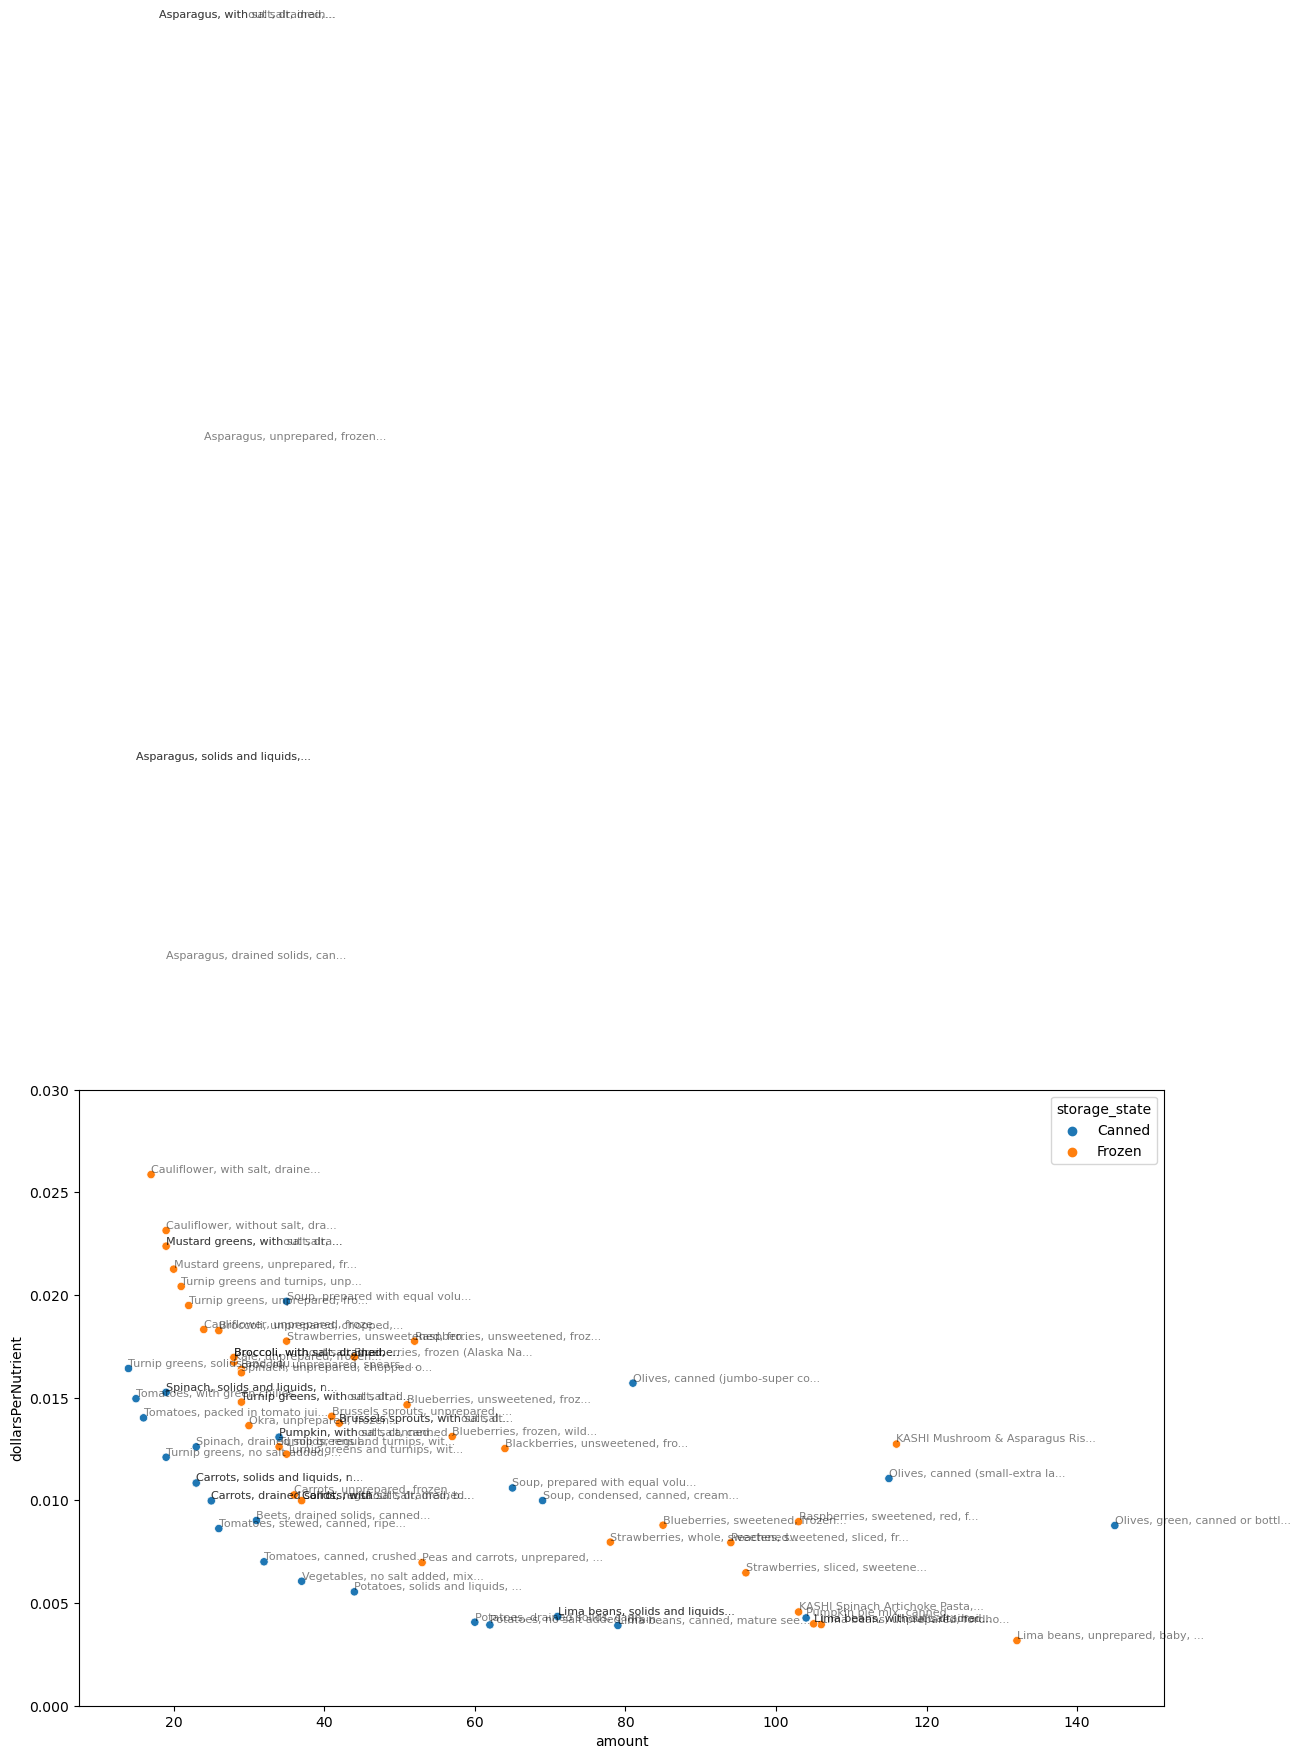

In [324]:
plt.figure(figsize=(14,8))

data=all[all.variable=='calories']

data = data.drop(data[data.name.str.contains('Corn dog')].index)

sns.scatterplot(data=data, x='amount', y='dollarsPerNutrient', hue='storage_state');

x = data.amount
y = data.dollarsPerNutrient
labels = data.name

# Add labels to the markers
for i, label in enumerate(labels):
    plt.text(x.iloc[i], y.iloc[i], label[:30]+'...', ha='left', va='bottom', fontsize=8, alpha=0.5)
    
plt.ylim((0,0.03));

# Daily Value Requirements

In [50]:
import requests
from bs4 import BeautifulSoup

# URL of the webpage
url = "https://www.fda.gov/food/nutrition-facts-label/daily-value-nutrition-and-supplement-facts-labels"

# Send a GET request to the webpage
response = requests.get(url)

# Parse the HTML content of the webpage using BeautifulSoup
soup = BeautifulSoup(response.content, "html.parser")

# Find the table by its class name
table = soup.find("table", {"class": "table table-bordered"})

# Extract table data and convert it to a DataFrame
table_data = []
for row in table.find_all("tr"):
    row_data = [cell.get_text(strip=True) for cell in row.find_all(["th", "td"])]
    table_data.append(row_data)

dv = pd.DataFrame(table_data[1:], columns=table_data[0])
dv

,Nutrient,Current Daily Value
0,Added sugars,50g
1,Biotin,30mcg
2,Calcium,1300mg
3,Chloride,2300mg
4,Choline,550mg
5,Cholesterol,300mg
6,Chromium,35mcg
7,Copper,0.9mg
8,Dietary Fiber,28g
9,Fat,78g


In [51]:
# add calories

dv.loc[dv.index.size] = ['calories', '2000Kcal']
dv

,Nutrient,Current Daily Value
0,Added sugars,50g
1,Biotin,30mcg
2,Calcium,1300mg
3,Chloride,2300mg
4,Choline,550mg
5,Cholesterol,300mg
6,Chromium,35mcg
7,Copper,0.9mg
8,Dietary Fiber,28g
9,Fat,78g


In [52]:
# split Daily Value from string into numeric amount and unit of measure

pattern = r'(\d+(?:\.\d+)?)\s?(\D+)?'
dv[['DV_amount','DV_UOM']] = dv['Current Daily Value'].str.extract(pattern)
dv['DV_amount'] = pd.to_numeric(dv['DV_amount'],errors='coerce')
dv = dv.drop(labels=['Current Daily Value'], axis=1)
dv['Nutrient'] = dv['Nutrient'].str.lower()
dv

,Nutrient,DV_amount,DV_UOM
0,added sugars,50.0,g
1,biotin,30.0,mcg
2,calcium,1300.0,mg
3,chloride,2300.0,mg
4,choline,550.0,mg
5,cholesterol,300.0,mg
6,chromium,35.0,mcg
7,copper,0.9,mg
8,dietary fiber,28.0,g
9,fat,78.0,g


In [53]:
all['variable'].unique()

array(['serving_size', 'calories', 'total_fat', 'saturated_fat',
       'cholesterol', 'sodium', 'choline', 'folate', 'folic_acid',
       'niacin', 'pantothenic_acid', 'riboflavin', 'thiamin', 'vitamin_a',
       'vitamin_a_rae', 'carotene_alpha', 'carotene_beta',
       'cryptoxanthin_beta', 'lutein_zeaxanthin', 'lucopene',
       'vitamin_b12', 'vitamin_b6', 'vitamin_c', 'vitamin_d', 'vitamin_e',
       'tocopherol_alpha', 'vitamin_k', 'calcium', 'copper', 'irom',
       'magnesium', 'manganese', 'phosphorous', 'potassium', 'selenium',
       'zink', 'protein', 'alanine', 'arginine', 'aspartic_acid',
       'cystine', 'glutamic_acid', 'glycine', 'histidine',
       'hydroxyproline', 'isoleucine', 'leucine', 'lysine', 'methionine',
       'phenylalanine', 'proline', 'serine', 'threonine', 'tryptophan',
       'tyrosine', 'valine', 'carbohydrate', 'fiber', 'sugars',
       'fructose', 'galactose', 'glucose', 'lactose', 'maltose',
       'sucrose', 'fat', 'saturated_fatty_acids',
     

In [54]:
dv['Nutrient'].unique()

array(['added sugars', 'biotin', 'calcium', 'chloride', 'choline',
       'cholesterol', 'chromium', 'copper', 'dietary fiber', 'fat',
       'folate/folic acid', 'iodine', 'iron', 'magnesium', 'manganese',
       'molybdenum', 'niacin', 'pantothenic acid', 'phosphorus',
       'potassium', 'protein', 'riboflavin', 'saturated fat', 'selenium',
       'sodium', 'thiamin', 'total carbohydrate', 'vitamin a',
       'vitamin b6', 'vitamin b12', 'vitamin c', 'vitamin d', 'vitamin e',
       'vitamin k', 'zinc', 'calories'], dtype=object)

In [55]:
matches = fuzzymatch(all['variable'].drop_duplicates(), dv['Nutrient'].drop_duplicates(), 90)
matches

0.0 seconds elapsed


,variable,Nutrient,score
0,calories,calories,100.000000
1,total_fat,fat,90.000000
2,saturated_fat,saturated fat,100.000000
3,cholesterol,cholesterol,100.000000
4,sodium,sodium,100.000000
5,choline,choline,100.000000
6,folate,folate/folic acid,90.000000
7,folic_acid,folate/folic acid,90.000000
8,niacin,niacin,100.000000
9,pantothenic_acid,pantothenic acid,100.000000


In [56]:
all = all.merge(matches.iloc[:,:2], on='variable').merge(dv, on="Nutrient")
all

,name,Item,variable,amount,unit of measure,Form,RetailPrice,PricePer100Grams,dollarsPerNutrient,Nutrient,DV_amount,DV_UOM
0,Cornstarch,Corn,calories,381.00,NaN,Fresh,1.8908,0.416850,0.001094,calories,2000.0,Kcal
1,Cornstarch,Corn,calories,381.00,NaN,Canned,1.0287,0.226790,0.000595,calories,2000.0,Kcal
2,Cornstarch,Corn,calories,381.00,NaN,Frozen,1.6642,0.366893,0.000963,calories,2000.0,Kcal
3,"Snacks, cakes, popcorn",Corn,calories,384.00,NaN,Fresh,1.8908,0.416850,0.001086,calories,2000.0,Kcal
4,"Snacks, cakes, popcorn",Corn,calories,384.00,NaN,Canned,1.0287,0.226790,0.000591,calories,2000.0,Kcal
...,...,...,...,...,...,...,...,...,...,...,...,...
33223,"Corn with red and green peppers, solids and li...",Green peppers,sugars,0.00,NaN,Fresh,1.2772,0.281574,inf,added sugars,50.0,g
33224,"Tomato products, and celery, green peppers, wi...",Green peppers,sugars,7.36,g,Fresh,1.2772,0.281574,0.038257,added sugars,50.0,g
33225,"Restaurant, Arroz con frijoles negros (rice an...",Black beans,sugars,0.86,g,Canned,1.0281,0.226657,0.263555,added sugars,50.0,g
33226,"Restaurant, Arroz con frijoles negros (rice an...",Black beans,sugars,0.86,g,Dried,1.3753,0.303202,0.352560,added sugars,50.0,g


In [57]:
all['PercentOfDV'] = all['amount']/all['DV_amount']
all['CostForEntireDV'] = all['DV_amount']/all['amount'] * all['RetailPrice']
all

,name,Item,variable,amount,unit of measure,Form,RetailPrice,PricePer100Grams,dollarsPerNutrient,Nutrient,DV_amount,DV_UOM,PercentOfDV,CostForEntireDV
0,Cornstarch,Corn,calories,381.00,NaN,Fresh,1.8908,0.416850,0.001094,calories,2000.0,Kcal,0.1905,9.925459
1,Cornstarch,Corn,calories,381.00,NaN,Canned,1.0287,0.226790,0.000595,calories,2000.0,Kcal,0.1905,5.400000
2,Cornstarch,Corn,calories,381.00,NaN,Frozen,1.6642,0.366893,0.000963,calories,2000.0,Kcal,0.1905,8.735958
3,"Snacks, cakes, popcorn",Corn,calories,384.00,NaN,Fresh,1.8908,0.416850,0.001086,calories,2000.0,Kcal,0.1920,9.847917
4,"Snacks, cakes, popcorn",Corn,calories,384.00,NaN,Canned,1.0287,0.226790,0.000591,calories,2000.0,Kcal,0.1920,5.357812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33223,"Corn with red and green peppers, solids and li...",Green peppers,sugars,0.00,NaN,Fresh,1.2772,0.281574,inf,added sugars,50.0,g,0.0000,inf
33224,"Tomato products, and celery, green peppers, wi...",Green peppers,sugars,7.36,g,Fresh,1.2772,0.281574,0.038257,added sugars,50.0,g,0.1472,8.676630
33225,"Restaurant, Arroz con frijoles negros (rice an...",Black beans,sugars,0.86,g,Canned,1.0281,0.226657,0.263555,added sugars,50.0,g,0.0172,59.773256
33226,"Restaurant, Arroz con frijoles negros (rice an...",Black beans,sugars,0.86,g,Dried,1.3753,0.303202,0.352560,added sugars,50.0,g,0.0172,79.959302


In [58]:
all.sort_values(['variable','CostForEntireDV']).head()

,name,Item,variable,amount,unit of measure,Form,RetailPrice,PricePer100Grams,dollarsPerNutrient,Nutrient,DV_amount,DV_UOM,PercentOfDV,CostForEntireDV
23832,"Babyfood, dry, with bananas, mixed, cereal",Bananas,calcium,696.0,mg,Fresh,0.5249,0.115721,0.000166,calcium,1300.0,mg,0.535385,0.980417
23833,"Babyfood, dry, with bananas, rice, cereal",Bananas,calcium,691.0,mg,Fresh,0.5249,0.115721,0.000167,calcium,1300.0,mg,0.531538,0.987511
23830,"Babyfood, dry, with bananas, oatmeal, cereal",Bananas,calcium,651.0,mg,Fresh,0.5249,0.115721,0.000178,calcium,1300.0,mg,0.500769,1.048187
23702,"Babyfood, dry, rice and apples",Apples,calcium,850.0,mg,Fresh,1.5193,0.334948,0.000394,calcium,1300.0,mg,0.653846,2.323635
23408,"Potatoes, unprepared, dry mix, au gratin",Potatoes,calcium,311.0,mg,Fresh,0.6682,0.147313,0.000474,calcium,1300.0,mg,0.239231,2.793119


In [59]:
all['rank_CostForEntireDV'] = all.groupby(['variable', 'Form'])['CostForEntireDV'].rank()
all.sort_values(['variable', 'rank_CostForEntireDV'])[(all['variable']=='calories') & (all['Form']=='Fresh')]

/var/folders/l8/tbybt_pn2j3_tzq2f_xysh340000gp/T/ipykernel_5682/2402948871.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  all.sort_values(['variable', 'rank_CostForEntireDV'])[(all['variable']=='calories') & (all['Form']=='Fresh')]


,name,Item,variable,amount,unit of measure,Form,RetailPrice,PricePer100Grams,dollarsPerNutrient,Nutrient,DV_amount,DV_UOM,PercentOfDV,CostForEntireDV,rank_CostForEntireDV
642,"Seeds, dried, watermelon seed kernels",Watermelon,calories,557.0,NaN,Fresh,0.3604,0.079455,0.000143,calories,2000.0,Kcal,0.2785,1.294075,1.0
435,"Snacks, cheese-flavor, made from dried potatoe...",Potatoes,calories,551.0,NaN,Fresh,0.6682,0.147313,0.000267,calories,2000.0,Kcal,0.2755,2.425408,2.0
391,"Snack, plain, made from dried potatoes, potato...",Potatoes,calories,545.0,NaN,Fresh,0.6682,0.147313,0.000270,calories,2000.0,Kcal,0.2725,2.452110,3.0
758,"Babyfood, dry, with bananas, rice, cereal",Bananas,calories,404.0,NaN,Fresh,0.5249,0.115721,0.000286,calories,2000.0,Kcal,0.2020,2.598515,4.0
447,"Snacks, reduced fat, made from dried potatoes,...",Potatoes,calories,502.0,NaN,Fresh,0.6682,0.147313,0.000293,calories,2000.0,Kcal,0.2510,2.662151,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
711,"Asparagus, without salt, drained, boiled, cook...",Asparagus,calories,18.0,NaN,Fresh,2.7576,0.607947,0.033775,calories,2000.0,Kcal,0.0090,306.400000,383.5
528,"Turnip greens, solids and liquids, canned",Turnip greens,calories,14.0,NaN,Fresh,2.4176,0.532990,0.038071,calories,2000.0,Kcal,0.0070,345.371429,385.0
705,"Asparagus, solids and liquids, no salt added, ...",Asparagus,calories,15.0,NaN,Fresh,2.7576,0.607947,0.040530,calories,2000.0,Kcal,0.0075,367.680000,386.5
708,"Asparagus, solids and liquids, regular pack, c...",Asparagus,calories,15.0,NaN,Fresh,2.7576,0.607947,0.040530,calories,2000.0,Kcal,0.0075,367.680000,386.5


In [60]:
all[all['rank_CostForEntireDV']<=1 & (all['Form']=='Fresh')]

,name,Item,variable,amount,unit of measure,Form,RetailPrice,PricePer100Grams,dollarsPerNutrient,Nutrient,DV_amount,DV_UOM,PercentOfDV,CostForEntireDV,rank_CostForEntireDV
642,"Seeds, dried, watermelon seed kernels",Watermelon,calories,557.000,NaN,Fresh,0.3604,0.079455,0.000143,calories,2000.0,Kcal,0.278500,1.294075,1.0
1565,"Seeds, dried, watermelon seed kernels",Watermelon,total_fat,47.000,g,Fresh,0.3604,0.079455,0.001691,fat,78.0,g,0.602564,0.598111,1.0
2488,"Seeds, dried, watermelon seed kernels",Watermelon,fat,47.370,g,Fresh,0.3604,0.079455,0.001677,fat,78.0,g,0.607308,0.593439,1.0
3411,"Seeds, dried, watermelon seed kernels",Watermelon,saturated_fatty_acids,9.779,g,Fresh,0.3604,0.079455,0.008125,fat,78.0,g,0.125372,2.874650,1.0
4177,"Cake, prepared from recipe, pineapple upside-down",Pineapple,fatty_acids_total_trans,22.000,mg,Fresh,0.5685,0.125333,0.005697,fat,78.0,g,0.282051,2.015591,1.0
5257,"Seeds, dried, watermelon seed kernels",Watermelon,saturated_fat,9.800,g,Fresh,0.3604,0.079455,0.008108,saturated fat,20.0,g,0.490000,0.735510,1.0
5550,"Oil, corn and canola",Corn,monounsaturated_fatty_acids,58.537,g,Fresh,1.8908,0.416850,0.007121,saturated fat,20.0,g,2.926850,0.646019,1.0
7103,"Seeds, dried, watermelon seed kernels",Watermelon,polyunsaturated_fatty_acids,28.094,g,Fresh,0.3604,0.079455,0.002828,saturated fat,20.0,g,1.404700,0.256567,1.0
7869,"Cake, prepared from recipe, pineapple upside-down",Pineapple,cholesterol,22.000,mg,Fresh,0.5685,0.125333,0.005697,cholesterol,300.0,mg,0.073333,7.752273,1.0
8640,"Potatoes, unprepared, dry mix, au gratin",Potatoes,sodium,2095.000,mg,Fresh,0.6682,0.147313,0.000070,sodium,2300.0,mg,0.910870,0.733585,1.0
